# Predição de Precos de Carros Usados

Este notebook foi desenvolvido como parte do [Desafio Kaggle para Predição de Carros Usados](https://www.kaggle.com/competitions/playground-series-s4e9/overview). O objetivo deste desafio é prever o preço de um carro dado um conjunto de atributos.

Para avaliar a eficacia dos modelos de regressão, foi utilizada a função de Erro Quadrático Médio (RMSE).

$$
\text{RMSE} = \sqrt{\frac{1}{N} \sum_{i=1}^{N} (y_i - \hat{y}_i)^2}
$$

# Índice

- [1 - Importando-Bibliotecas](#1_Importando_Bibliotecas)
- [2 - Importando Dados](#2_Importando_Dados)
- [3 - Análise Exploratória de Dados](#3_Analise_Exploratoria-Dados)
- [5 - Tratamento dos Dados](#5_Tratamento_Dados)
- [6 - Treinamento dos Modelos](#6_Treinamento_Dos_Modelos)
- [7 - Calibrando os modelos](#7_Calibrando_os_modelos)
- [8 - Avaliando os modelos](#8_Avaliando_os_modelos)

In [1]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    IN_COLAB = True
    print("Está no google colab")
except:
    IN_COLAB = False
    print("Não está no google colab")

Não está no google colab


# 1_Importando_Bibliotecas

In [2]:
if IN_COLAB:
    !pip install -r /content/drive/Othercomputers/Meu-laptop/binary_prediction_poisonous_mushrooms/requirements.txt

In [3]:
import pandas as pd
#import kaggle
#from kaggle.api.kaggle_api_extended import KaggleApi
from sklearn.model_selection import train_test_split
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import numpy as np
import pickle
from pickle import UnpicklingError
import sys
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

# Tratamentos
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

# Treinamento
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from catboost import CatBoostClassifier
import keras
import keras_tuner
from keras import layers
from skopt import BayesSearchCV
from sklearn.model_selection import RandomizedSearchCV

##Avaliacao
from sklearn.metrics import classification_report,recall_score,roc_curve,confusion_matrix, precision_recall_curve, log_loss, brier_score_loss, accuracy_score
from sklearn.metrics import matthews_corrcoef
from sklearn.calibration import calibration_curve
from sklearn.model_selection import cross_val_predict

## Calibracao

from venn_abers import VennAbersCalibrator
from sklearn.base import BaseEstimator, RegressorMixin

2024-09-05 17:13:08.191326: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-05 17:13:08.483024: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-05 17:13:10.501824: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-05 17:13:12.387876: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-05 17:13:13.829229: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

In [4]:
import sys
sys.path.append('/home/vscode/.local/lib/python3.10/site-packages')
from feature_engine.transformation import LogCpTransformer, YeoJohnsonTransformer, BoxCoxTransformer

In [5]:
plt.style.use("ggplot")
%matplotlib inline
warnings.filterwarnings("ignore")
#pd.set_option('display.max_rows', None)

# 2_Importando_Dados

In [6]:
if IN_COLAB:
    sys.path.append("/content/drive/Othercomputers/Meu-laptop/binary_prediction_poisonous_mushrooms/dados")

    # Verifica os arquivos dentro da pasta 'dados'
    arquivos = os.listdir("/content/drive/Othercomputers/Meu-laptop/binary_prediction_poisonous_mushrooms/dados")

    diretorio = '/content/drive/Othercomputers/Meu-laptop/binary_prediction_poisonous_mushrooms/dados'


else:
    # Adiciona o caminho da pasta 'dados' ao sys.path
    sys.path.append("dados")

    # Verifica os arquivos dentro da pasta 'dados'
    arquivos = os.listdir("dados")

    diretorio = 'dados'

if "train_split.csv" not in arquivos or "test_split.csv" not in arquivos:
    dados = pd.read_csv(diretorio + "/train.csv")
    train, test  = train_test_split(dados, test_size=0.2)
    train.to_csv(diretorio + "/train_split.csv", index=False)
    test.to_csv(diretorio + "/test_split.csv", index=False)
    predict = pd.read_csv(diretorio + "/test.csv")

else:
    train = pd.read_csv(diretorio + "/train_split.csv")
    test = pd.read_csv(diretorio + "/test_split.csv")
    predict = pd.read_csv(diretorio + "/test.csv")

# 3_Analise_Exploratoria-Dados

Retirando o `id` dados de test e train

In [7]:
id_train = train["id"]
id_test = test["id"]
train.drop("id", axis=1, inplace=True)
test.drop("id", axis=1, inplace=True)
print(train.head())
test.head()

  brand             model  model_year  milage fuel_type  \
0   BMW      X1 sDrive28i        2021   13900  Gasoline   
1   BMW  650 Gran Coupe i        2013   98658  Gasoline   
2   Kia     Sorento LX V6        2019   42479  Gasoline   
3  Land  Rover Defender X        2023    4283  Gasoline   
4  Ford         F-150 XLT        2019   35580  Gasoline   

                                          engine  \
0   228.0HP 2.0L 4 Cylinder Engine Gasoline Fuel   
1   445.0HP 4.4L 8 Cylinder Engine Gasoline Fuel   
2                           3.3L V6 24V GDI DOHC   
3              5.0L V8 32V GDI DOHC Supercharged   
4  325.0HP 2.7L V6 Cylinder Engine Gasoline Fuel   

                     transmission      ext_col      int_col  \
0  Transmission w/Dual Shift Mode         Gray        Brown   
1  Transmission w/Dual Shift Mode        White        Black   
2               6-Speed Automatic        Black  Satin Black   
3               8-Speed Automatic  Firenze Red        Black   
4                

brand                                 model  model_year  milage fuel_type  \
0   Land                   Rover Discovery LSE        2004  123921  Gasoline   
1  Lexus                           GX 460 Base        2012  212500  Gasoline   
2   Ford                            Mustang GT        1996  130000  Gasoline   
3   Land  Rover Range Rover Sport Supercharged        2007  118500  Gasoline   
4   Ford                             F-150 XLT        2019   69800  Gasoline   

                                          engine transmission ext_col int_col  \
0   217.0HP 4.6L 8 Cylinder Engine Gasoline Fuel          A/T   Green   Beige   
1   301.0HP 4.6L 8 Cylinder Engine Gasoline Fuel          A/T   Black   Beige   
2   300.0HP 5.4L 8 Cylinder Engine Gasoline Fuel  4-Speed A/T     Red    Gray   
3   300.0HP 4.2L 8 Cylinder Engine Gasoline Fuel  6-Speed A/T   Beige   Beige   
4  375.0HP 3.5L V6 Cylinder Engine Gasoline Fuel          A/T    Gray   Black   

                                 accident clean_title  price  
0                           None reported         Yes   6399  
1  At least 1 accident or damage reported         NaN  17599  
2  At least 1 accident or damage reported         Yes  10500  
3                           None reported         Yes   9950  
4                           None reported         Yes  28500

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150826 entries, 0 to 150825
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   brand         150826 non-null  object
 1   model         150826 non-null  object
 2   model_year    150826 non-null  int64 
 3   milage        150826 non-null  int64 
 4   fuel_type     146781 non-null  object
 5   engine        150826 non-null  object
 6   transmission  150826 non-null  object
 7   ext_col       150826 non-null  object
 8   int_col       150826 non-null  object
 9   accident      148843 non-null  object
 10  clean_title   133728 non-null  object
 11  price         150826 non-null  int64 
dtypes: int64(3), object(9)
memory usage: 13.8+ MB


In [9]:
train.describe()

model_year         milage         price
count  150826.000000  150826.000000  1.508260e+05
mean     2015.818473   65779.113422  4.363719e+04
std         5.665087   49769.913223  7.586056e+04
min      1974.000000     100.000000  2.000000e+03
25%      2013.000000   24213.000000  1.700000e+04
50%      2017.000000   57800.000000  3.075000e+04
75%      2020.000000   95500.000000  4.990000e+04
max      2024.000000  405000.000000  2.954083e+06

In [10]:
train.columns

Index(['brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine',
       'transmission', 'ext_col', 'int_col', 'accident', 'clean_title',
       'price'],
      dtype='object')

**Primeiro, verificamos a quantidade de valores faltantes por coluna.**

Identificamos que três colunas possuem valores faltantes:

- A coluna `clean_title` possui 11% de valores faltantes.
- A coluna `fuel_type` possui 3% de valores faltantes.
- A coluna `accident` possui 1% de valores faltantes.
"""

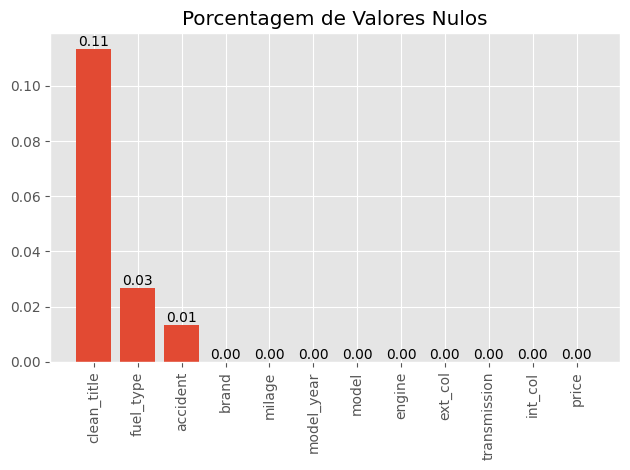

In [11]:
# Calcula a porcentagem de valores nulos
valor_nul = (train.isnull().sum() / train.shape[0]).sort_values(ascending=False)

# Cria os subplots
# Subplot para 'train'
plt.bar(valor_nul.index, valor_nul.values)
plt.title("Porcentagem de Valores Nulos")
plt.tick_params(axis="x", rotation=90)
for index, value in enumerate(valor_nul.values):
    plt.text(index, value, f"{value:.2f}", ha="center", va="bottom")

# Ajusta o layout para evitar sobreposição
plt.tight_layout()

# Exibe os gráficos
plt.show()

**Agora, verificamos as colunas numericas**

- A coluna `model_year` contém os anos de fabricação dos carros. Ao analisá-la, observa-se uma grande concentração de veículos fabricados entre os anos de 2010 e 2023, sendo o ano de 2021 o mais frequente. O ano mais antigo registrado é 1974.

- A coluna `milage`, que representa a quilometragem dos veículos, apresenta uma distribuição assimétrica, com maior concentração de valores à esquerda. No boxplot, a maioria dos valores está entre 24 mil e 95,5 mil quilômetros, com o terceiro quartil indicando o valor mais elevado. Aproximadamente 0,92% dos dados são considerados outliers. A diferença entre a média e a mediana é de 12,13%

- A coluna `price`, que é o alvo da predição, possui a maioria dos valores entre 17 mil e 49 mil. A porcentagem de outliers é de 5,72%. A diferença entre a média e a mediana é de 29,53%.


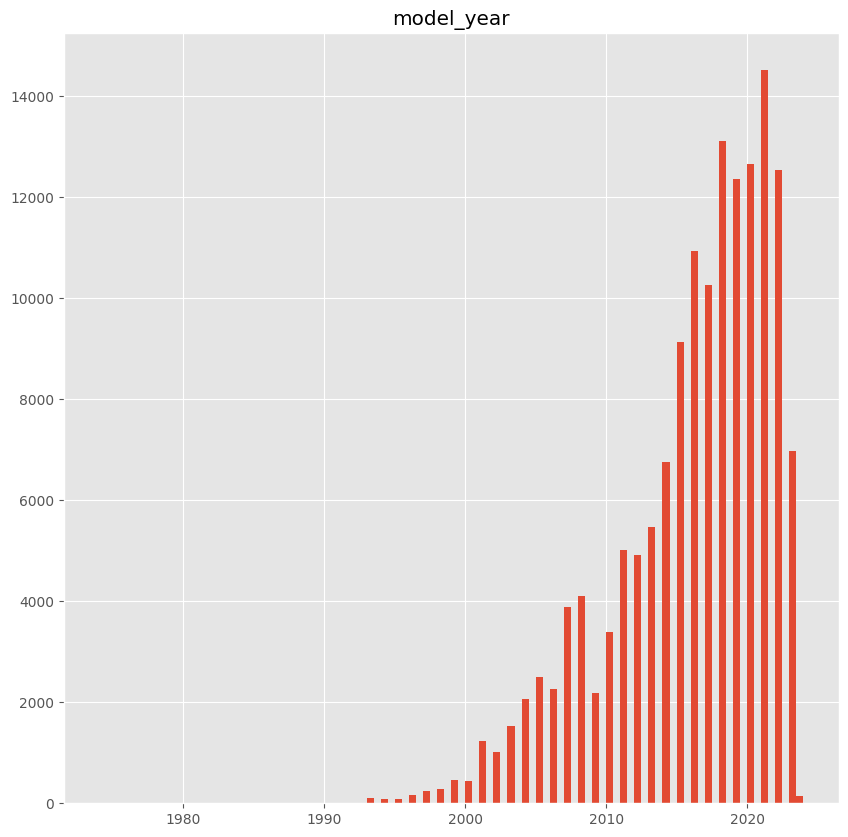

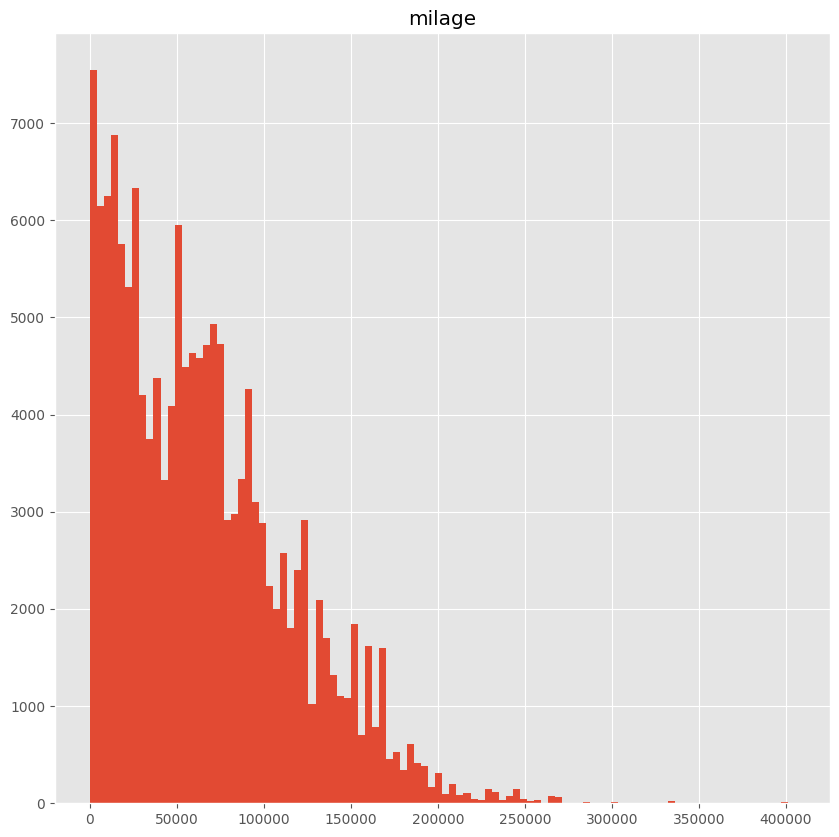

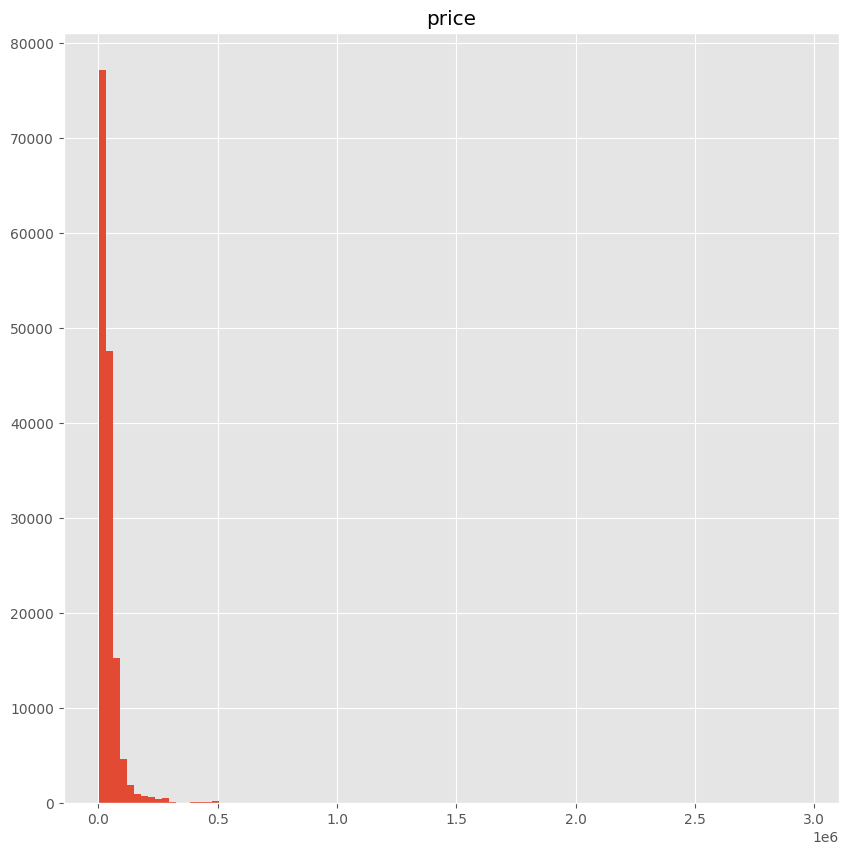

In [12]:
## plot histograma dos valores numericos
for col in train.columns:
    if train[col].dtype == "float64" or train[col].dtype == "int64":
        plt.figure(figsize=(10, 10))
        train[col].hist(bins=100)
        plt.title(col)
        plt.show()
        plt.close()

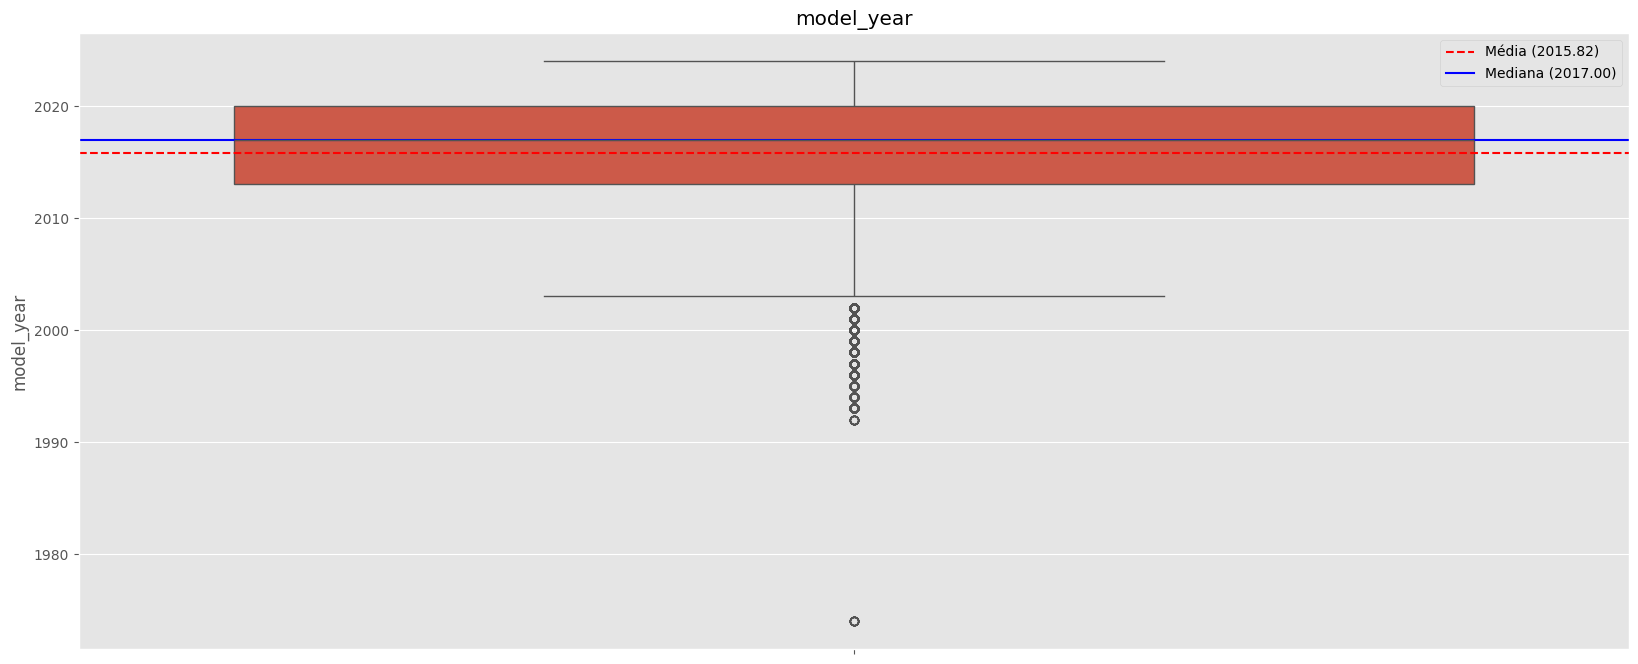

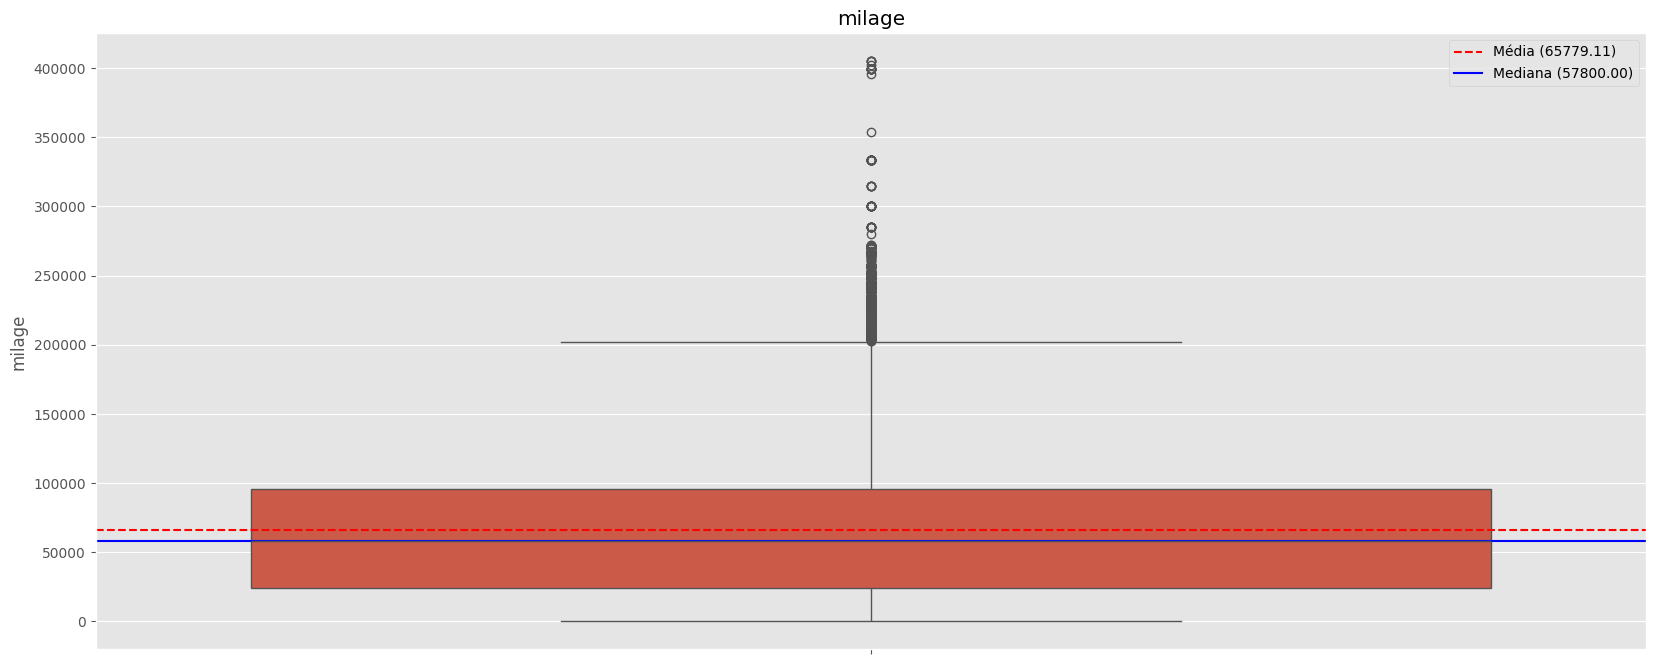

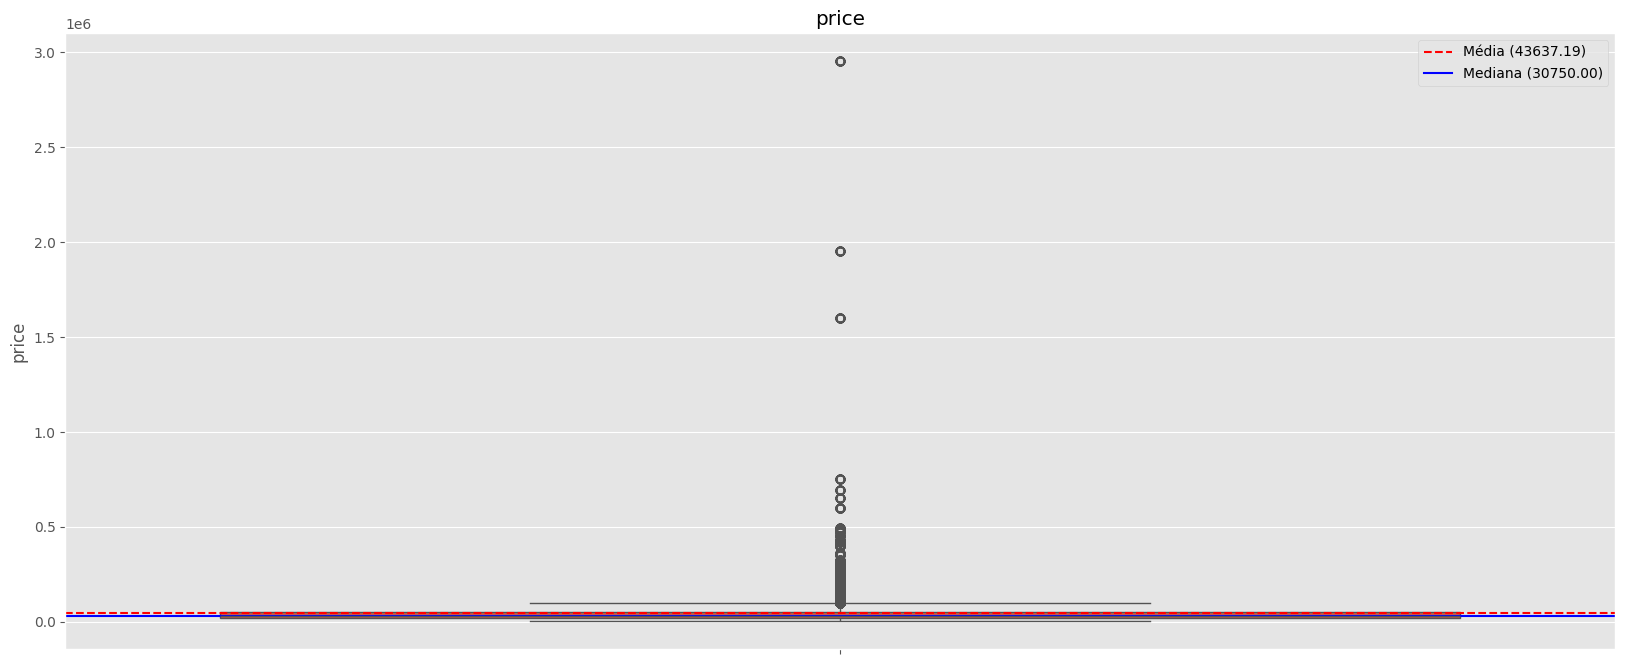

In [13]:
for col in train.columns:
    if train[col].dtype == "float64" or train[col].dtype == "int64":
        mean_value = train[col].mean()
        median_value = train[col].median()
        plt.figure(figsize=(20, 8))
        sns.boxplot(train[col],showfliers=True)
        plt.title(f"{col}")
        plt.axhline(
            y=mean_value, color="red", linestyle="--", label=f"Média ({mean_value:.2f})"
        )
        plt.axhline(
            y=median_value,
            color="blue",
            linestyle="-",
            label=f"Mediana ({median_value:.2f})",
        )
        plt.legend()
        plt.show()

In [14]:
# difernca percentual entre a media e a mediana
for col in train.columns:
    if train[col].dtype == "float64" or train[col].dtype == "int64":
        mean_value = train[col].mean()
        median_value = train[col].median()
        diff_mean_median = (mean_value - median_value) / mean_value * 100
        print(
            f"{col}: Diferença entre media e mediana dados train: {diff_mean_median:.2f} %"
        )

model_year: Diferença entre media e mediana dados train: -0.06 %
milage: Diferença entre media e mediana dados train: 12.13 %
price: Diferença entre media e mediana dados train: 29.53 %


In [15]:
# Porcentagem de outliers
for col in train.columns:
    if train[col].dtype == "float64" or train[col].dtype == "int64":
        Q1 = train[col].quantile(0.25)
        Q3 = train[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        upper_bound, lower_bound
        out_train = train[
            (train[col] < lower_bound) | (train[col] > upper_bound)
        ].shape[0]


        print(f"Explorando a porcentagem de outliers na coluna {col}")
        print(f"{col}: {out_train/train.shape[0]:.2%}")
        print("-------------------------------------------------------------")

Explorando a porcentagem de outliers na coluna model_year
model_year: 2.74%
-------------------------------------------------------------
Explorando a porcentagem de outliers na coluna milage
milage: 0.92%
-------------------------------------------------------------
Explorando a porcentagem de outliers na coluna price
price: 5.72%
-------------------------------------------------------------


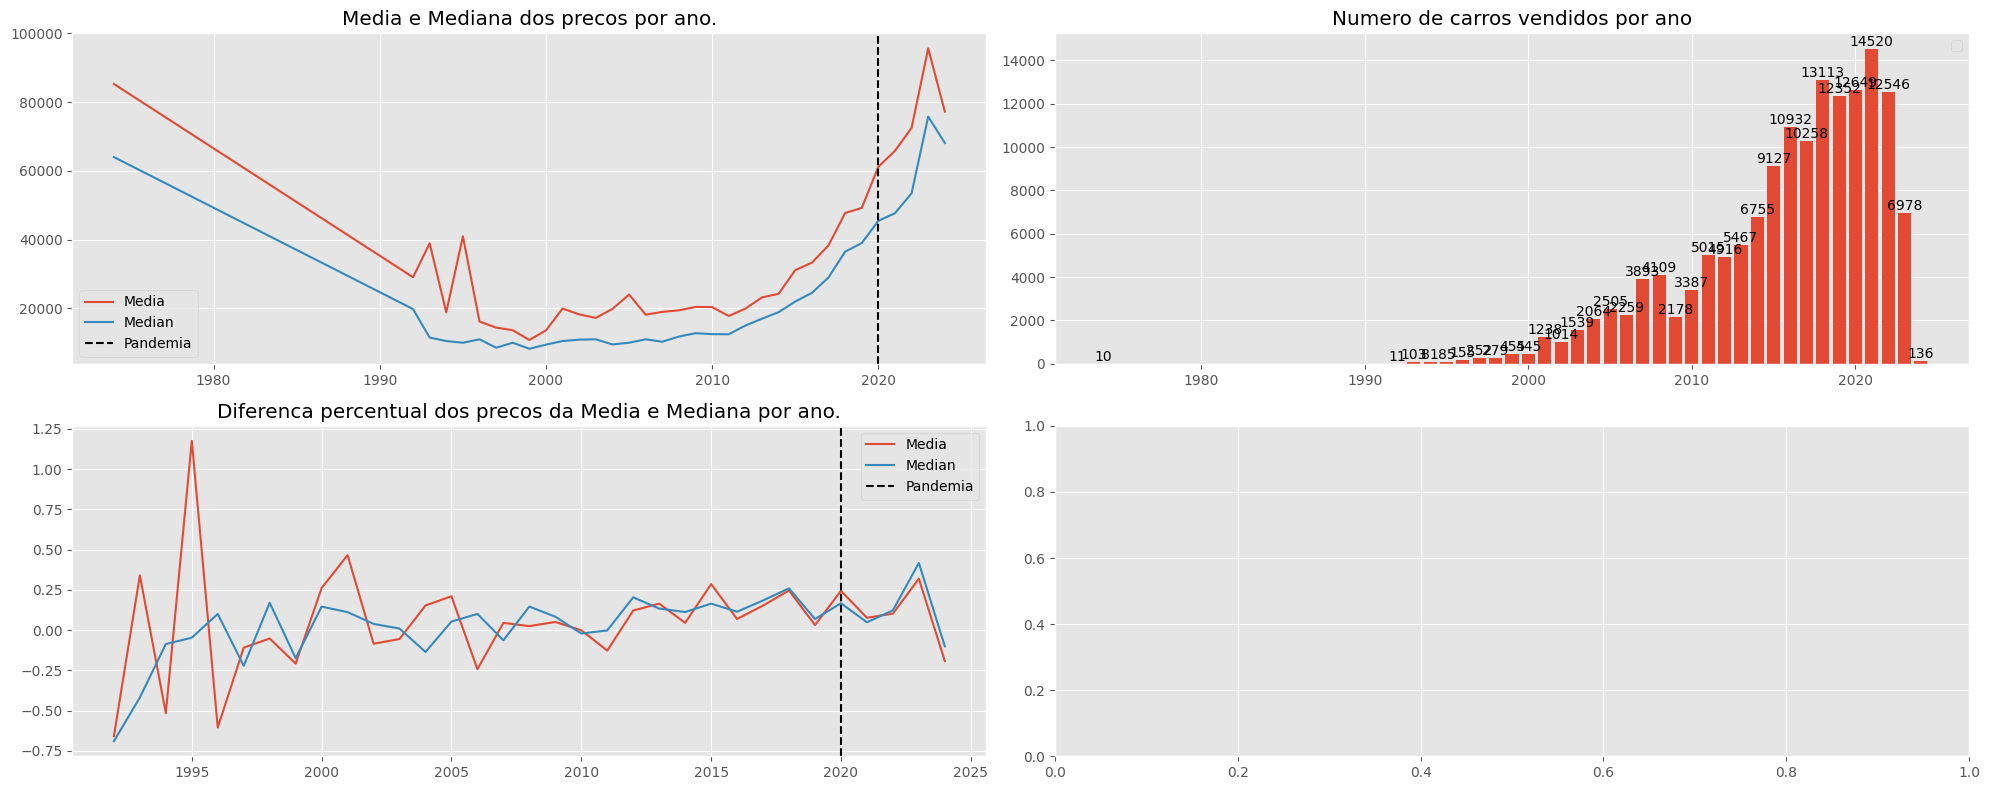

In [16]:
result = train.groupby("model_year")['price'].agg(["mean", "median"])
result_2 = train.groupby("model_year")['price'].count()
diferenca_percentual = result.pct_change()

fig, axes = plt.subplots(2, 2, figsize=(20, 8))

axes[0][0].plot(result.index, result['mean'], label="Media")
axes[0][0].plot(result.index, result['median'], label="Median")
axes[0][0].legend()
axes[0][0].set_title('Media e Mediana dos precos por ano.')
axes[0][0].axvline(
            x= 2020,
            color="black",
            linestyle="--",
            label="Pandemia",
        )
axes[0][0].legend()

axes[0][1].bar(result_2.index, result_2.values)
axes[0][1].legend()
axes[0][1].set_title('Numero de carros vendidos por ano')
for index, value in zip(result_2.index, result_2):
    axes[0][1].text(index, value, f"{value:.0f}", ha="center", va="bottom")
    

axes[1][0].plot(diferenca_percentual.index, diferenca_percentual['mean'], label="Media")
axes[1][0].plot(diferenca_percentual.index, diferenca_percentual['median'], label="Median")
axes[1][0].legend()
axes[1][0].axvline(
            x= 2020,
            color="black",
            linestyle="--",
            label="Pandemia",
        )
axes[1][0].set_title('Diferenca percentual dos precos da Media e Mediana por ano.')
axes[1][0].legend()
plt.tight_layout()
plt.show()

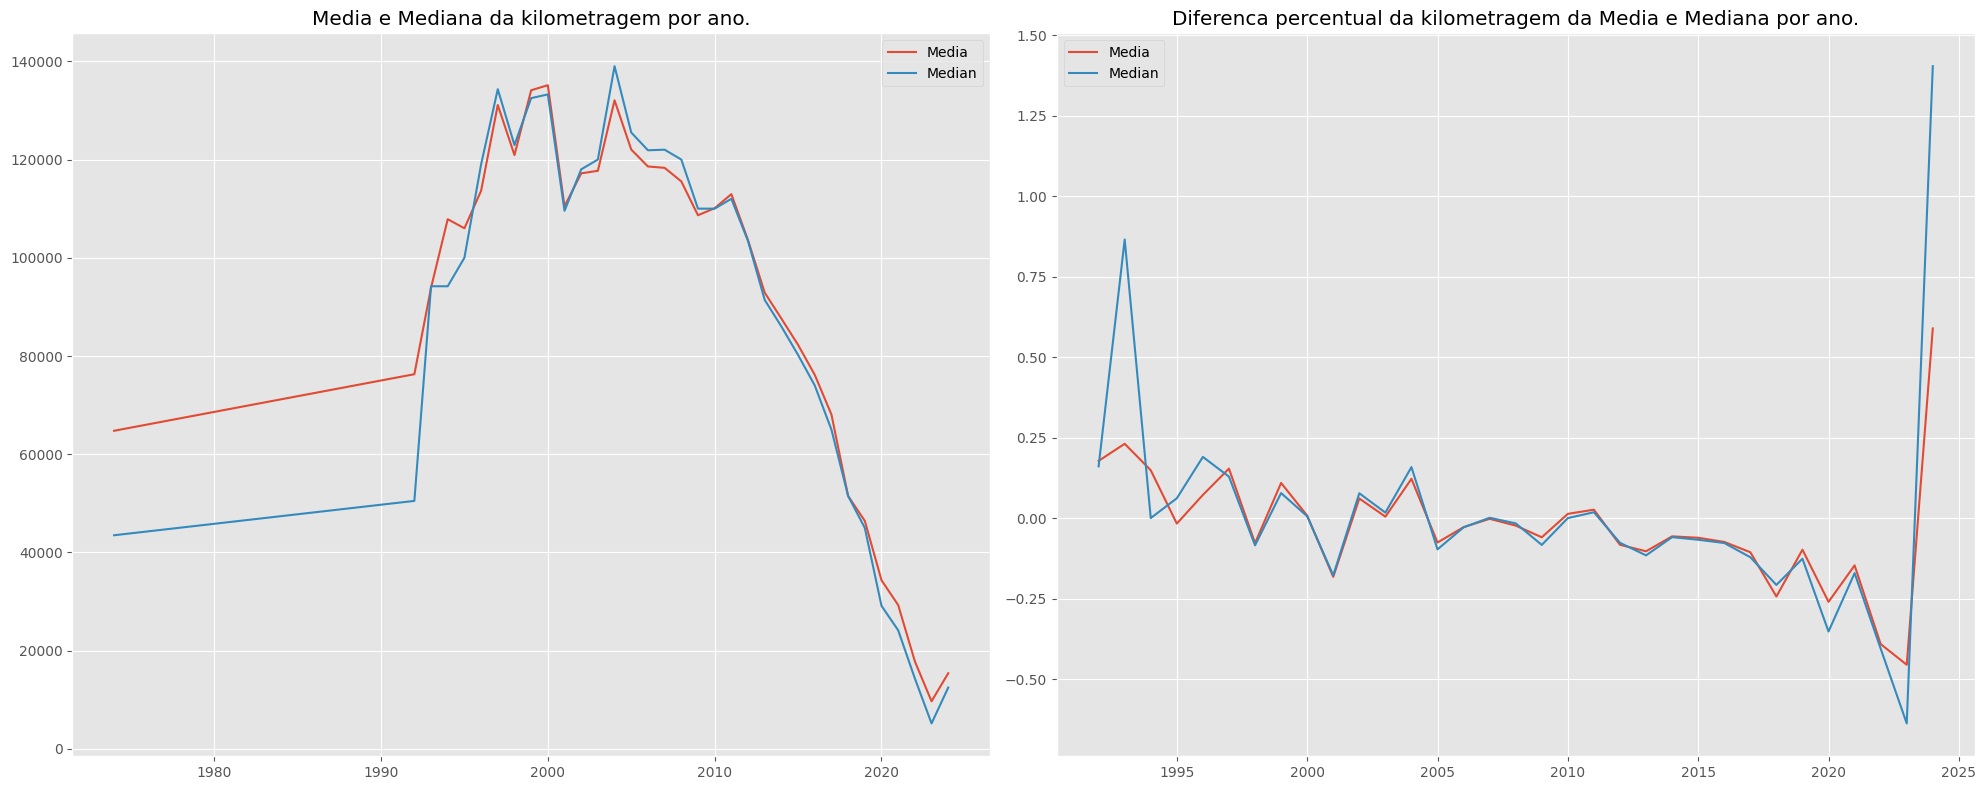

In [17]:
result = train.groupby("model_year")['milage'].agg(["mean", "median"])
result_2 = train.groupby("model_year")['milage'].count()
diferenca_percentual = result.pct_change()

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

axes[0].plot(result.index, result['mean'], label="Media")
axes[0].plot(result.index, result['median'], label="Median")
axes[0].legend()
axes[0].set_title('Media e Mediana da kilometragem por ano.')
axes[0].legend()

axes[1].plot(diferenca_percentual.index, diferenca_percentual['mean'], label="Media")
axes[1].plot(diferenca_percentual.index, diferenca_percentual['median'], label="Median")
axes[1].legend()
axes[1].set_title('Diferenca percentual da kilometragem da Media e Mediana por ano.')
axes[1].legend()
plt.tight_layout()
plt.show()

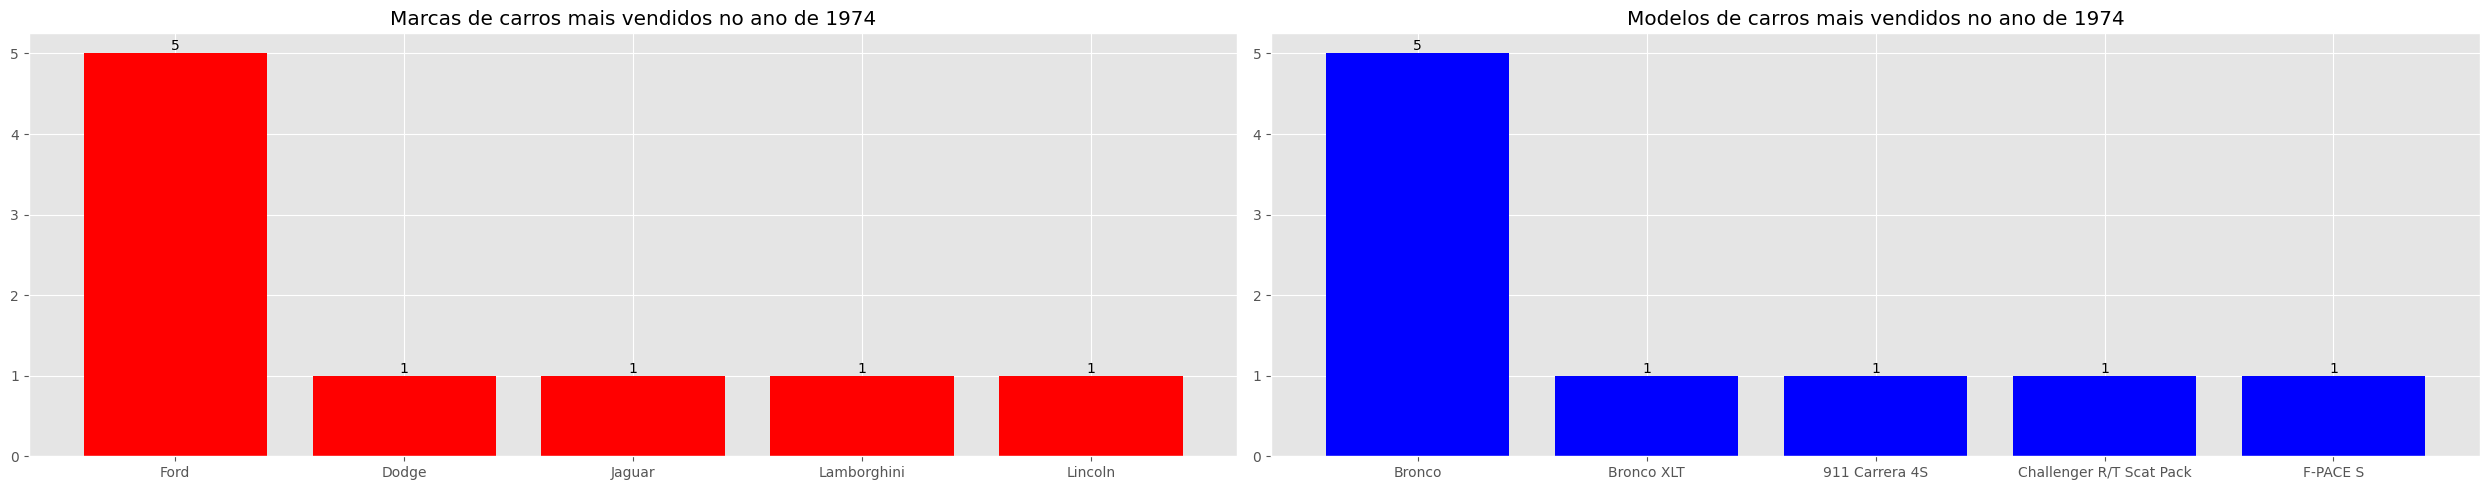

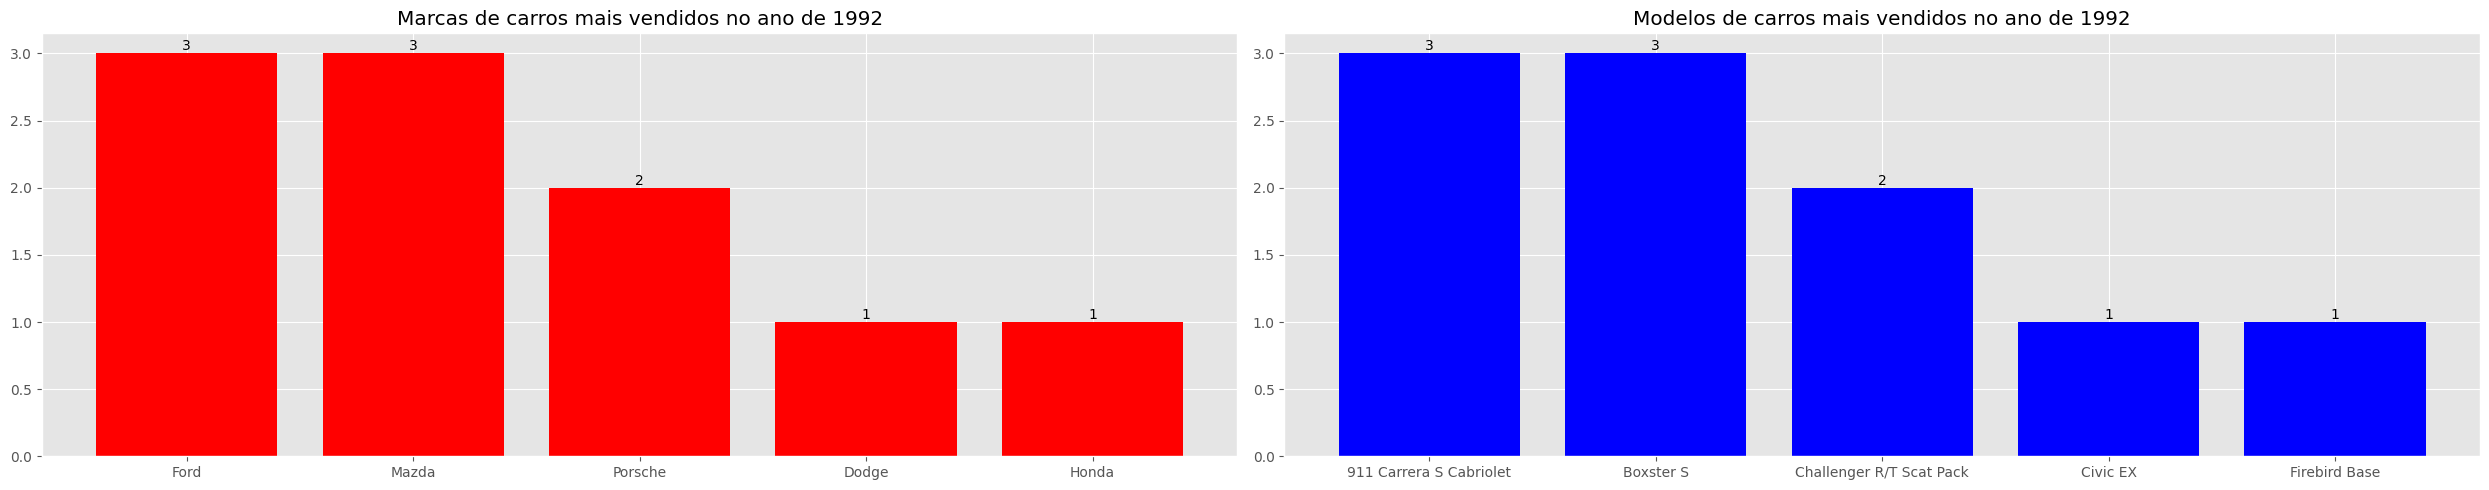

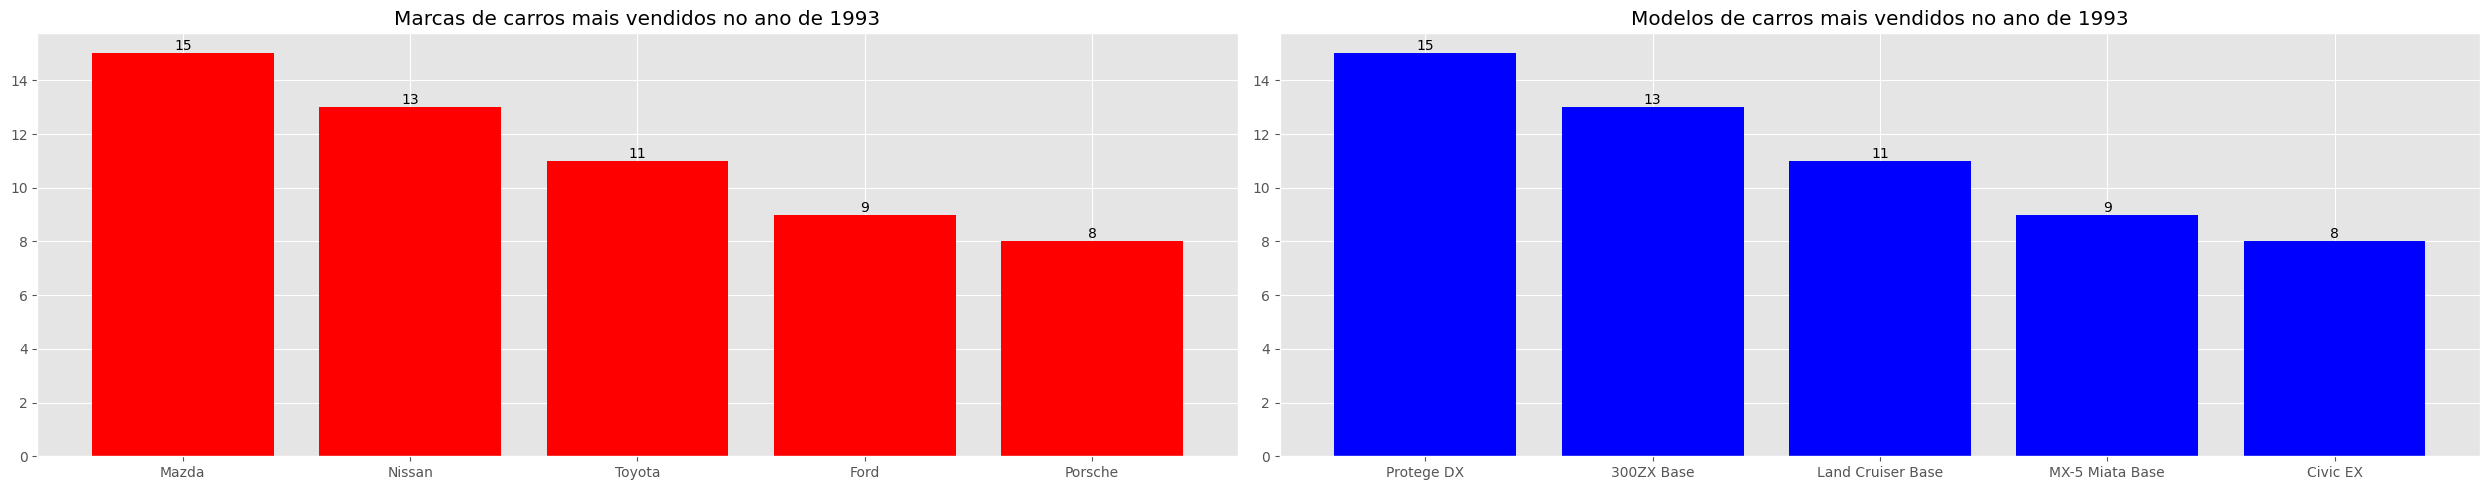

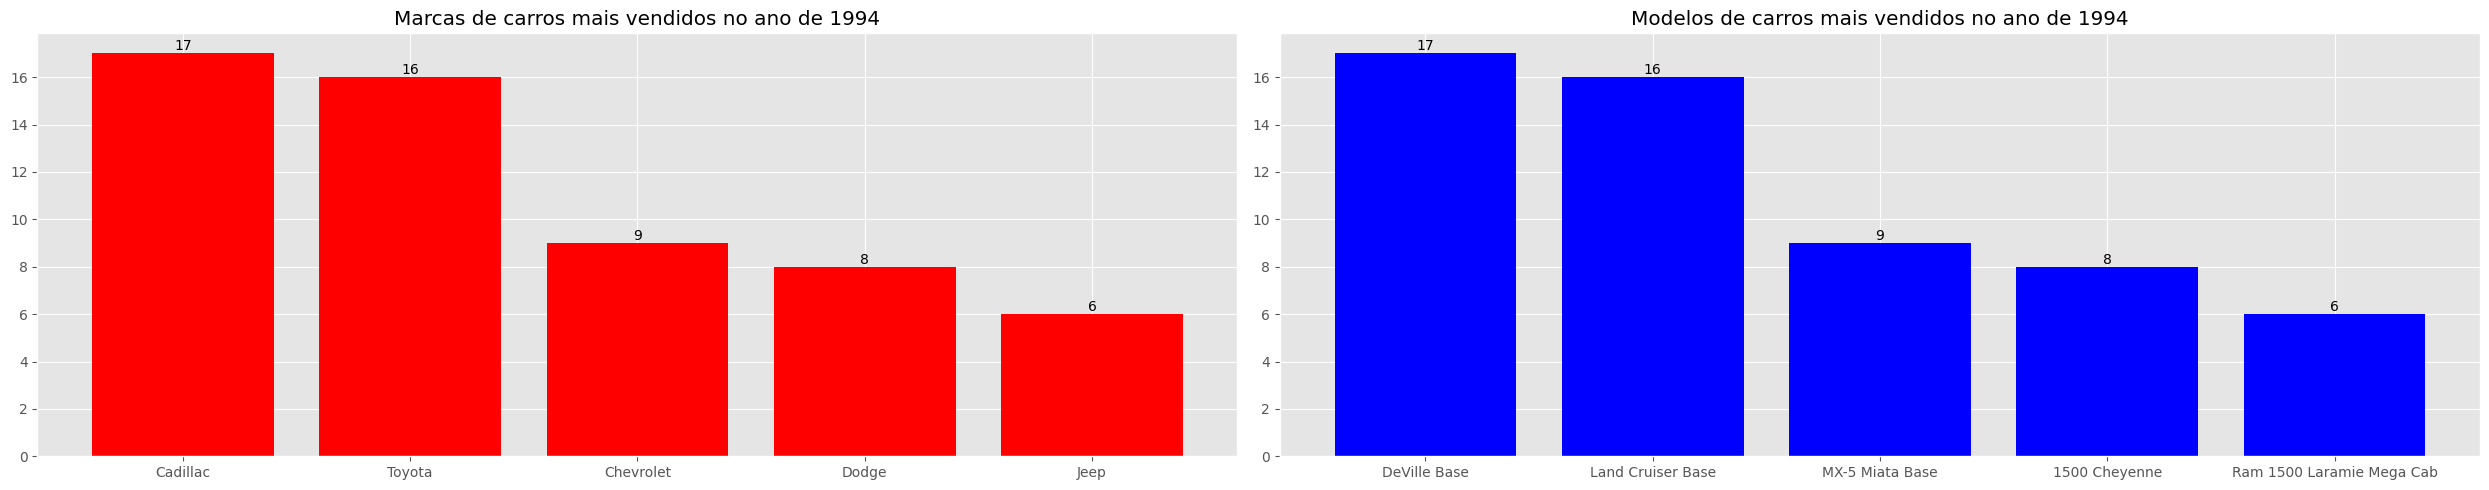

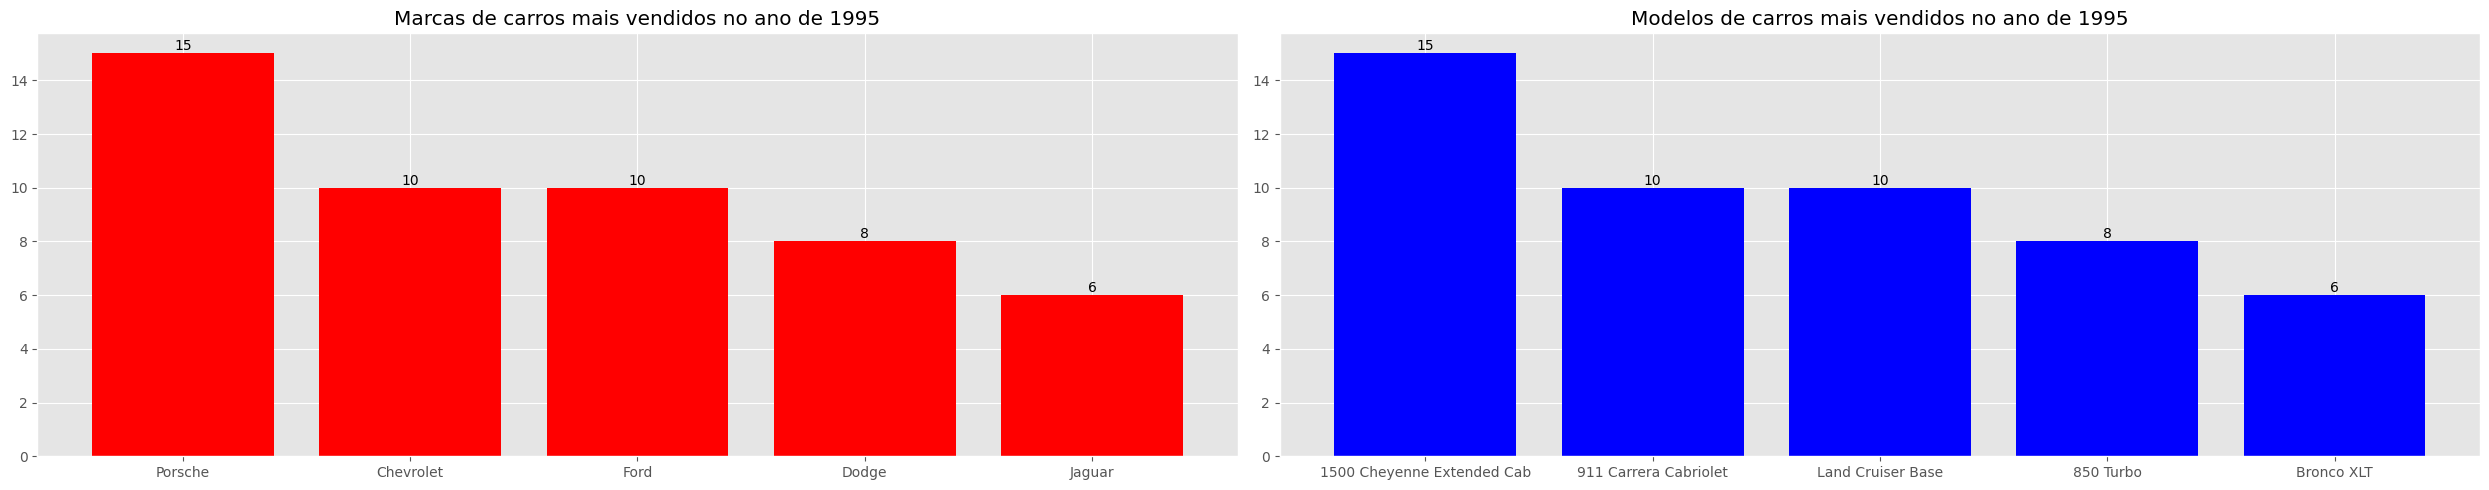

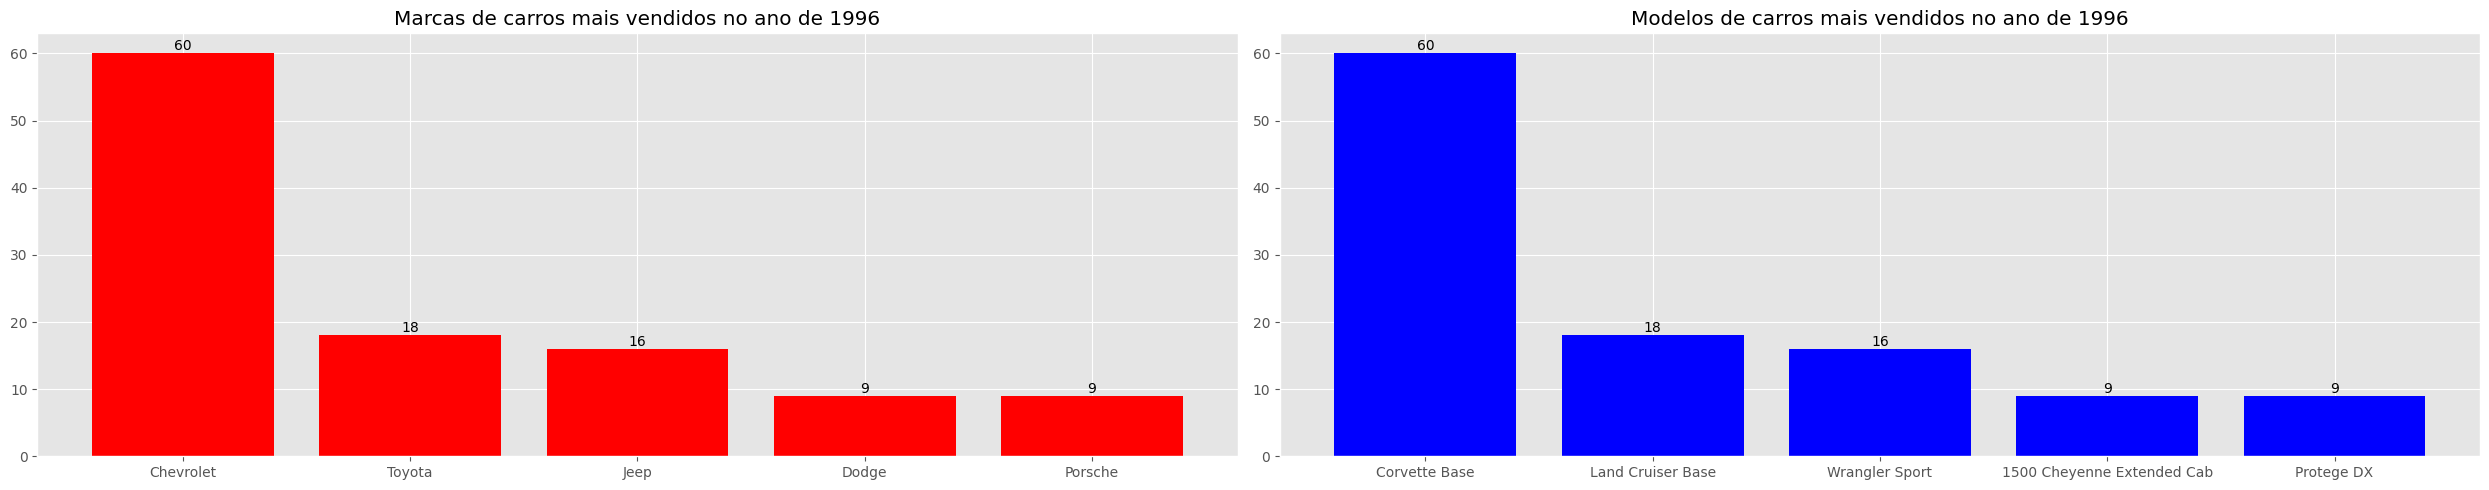

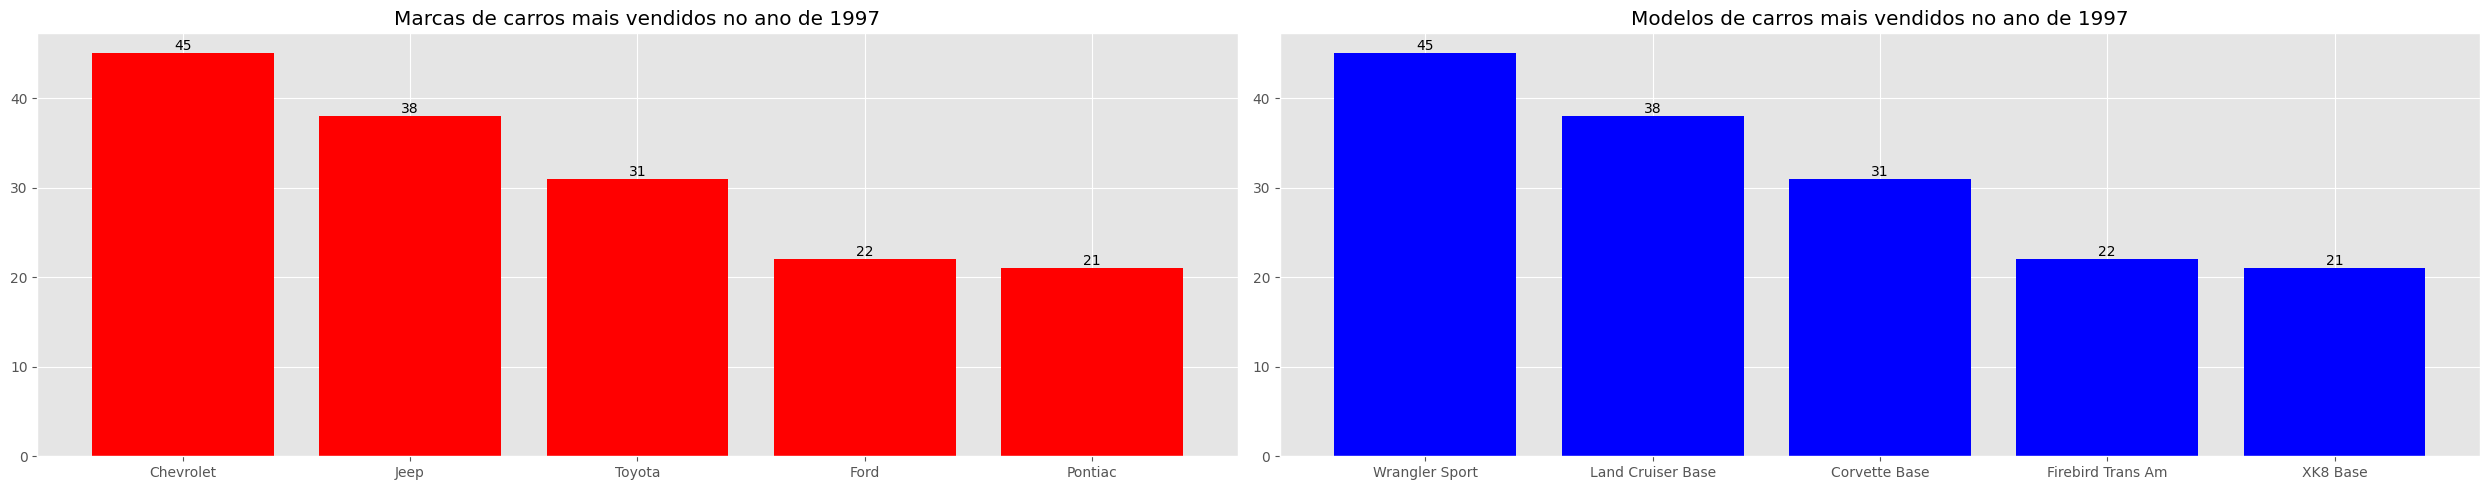

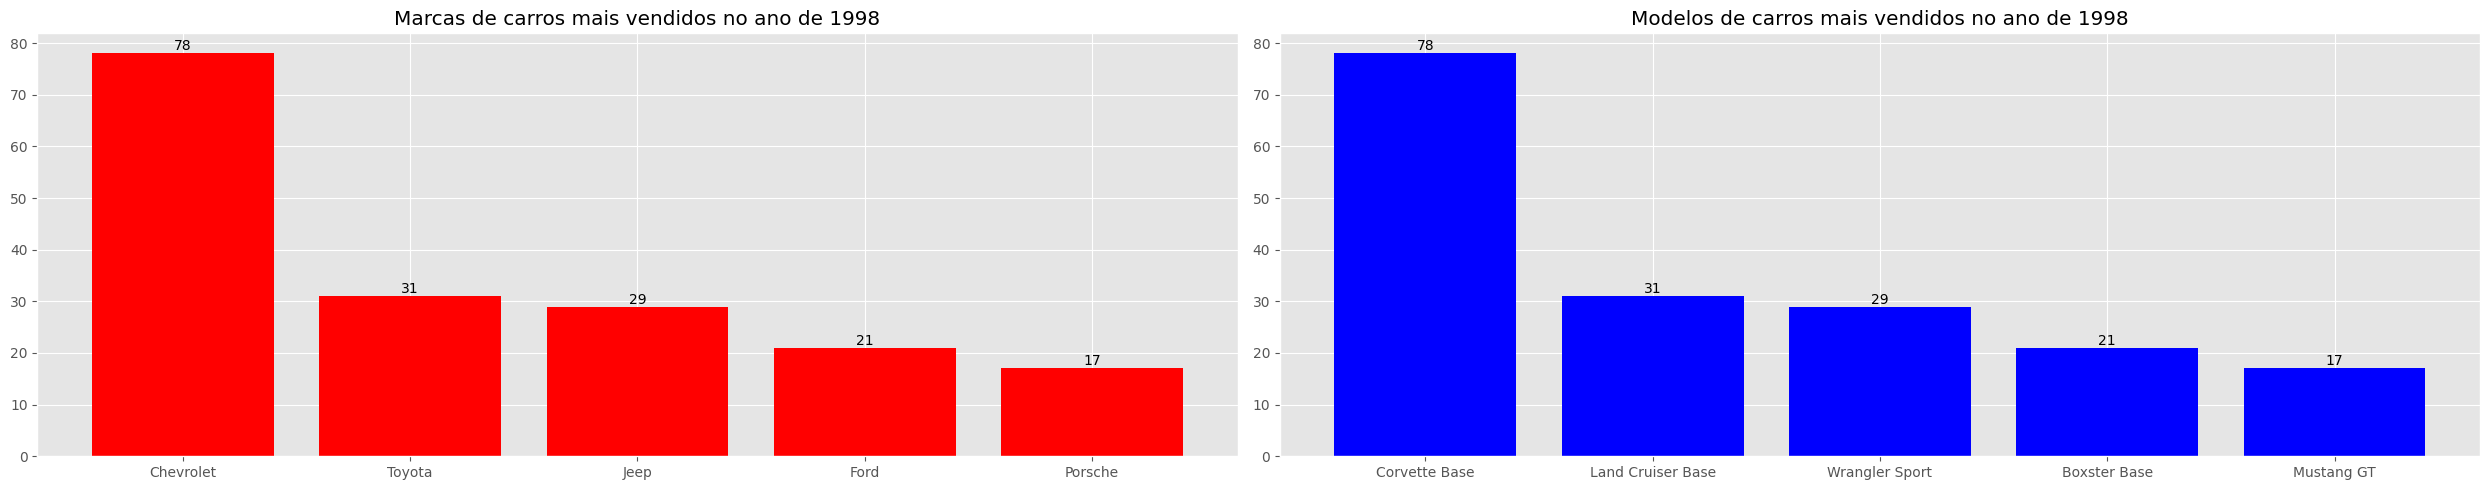

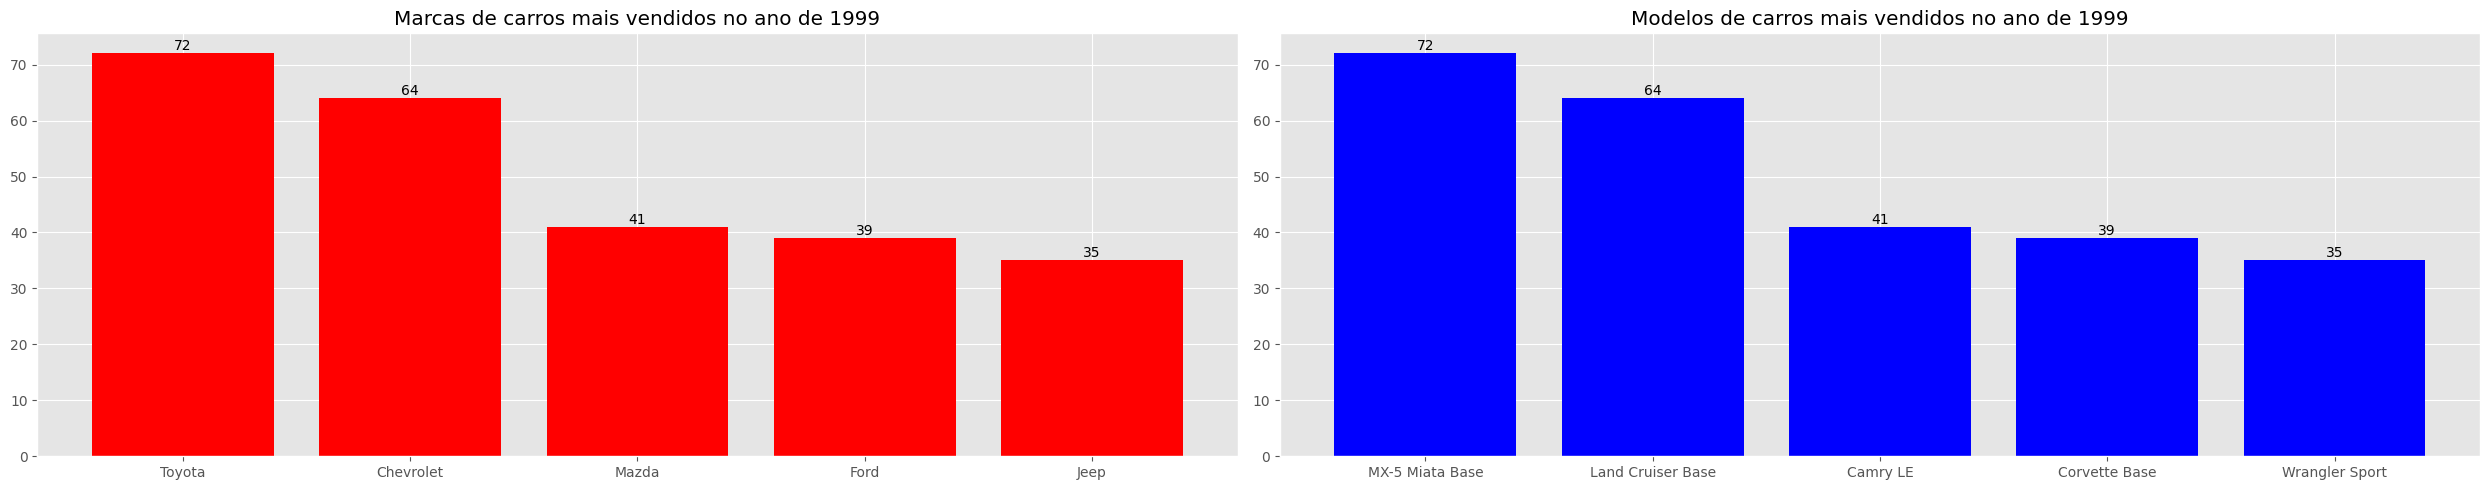

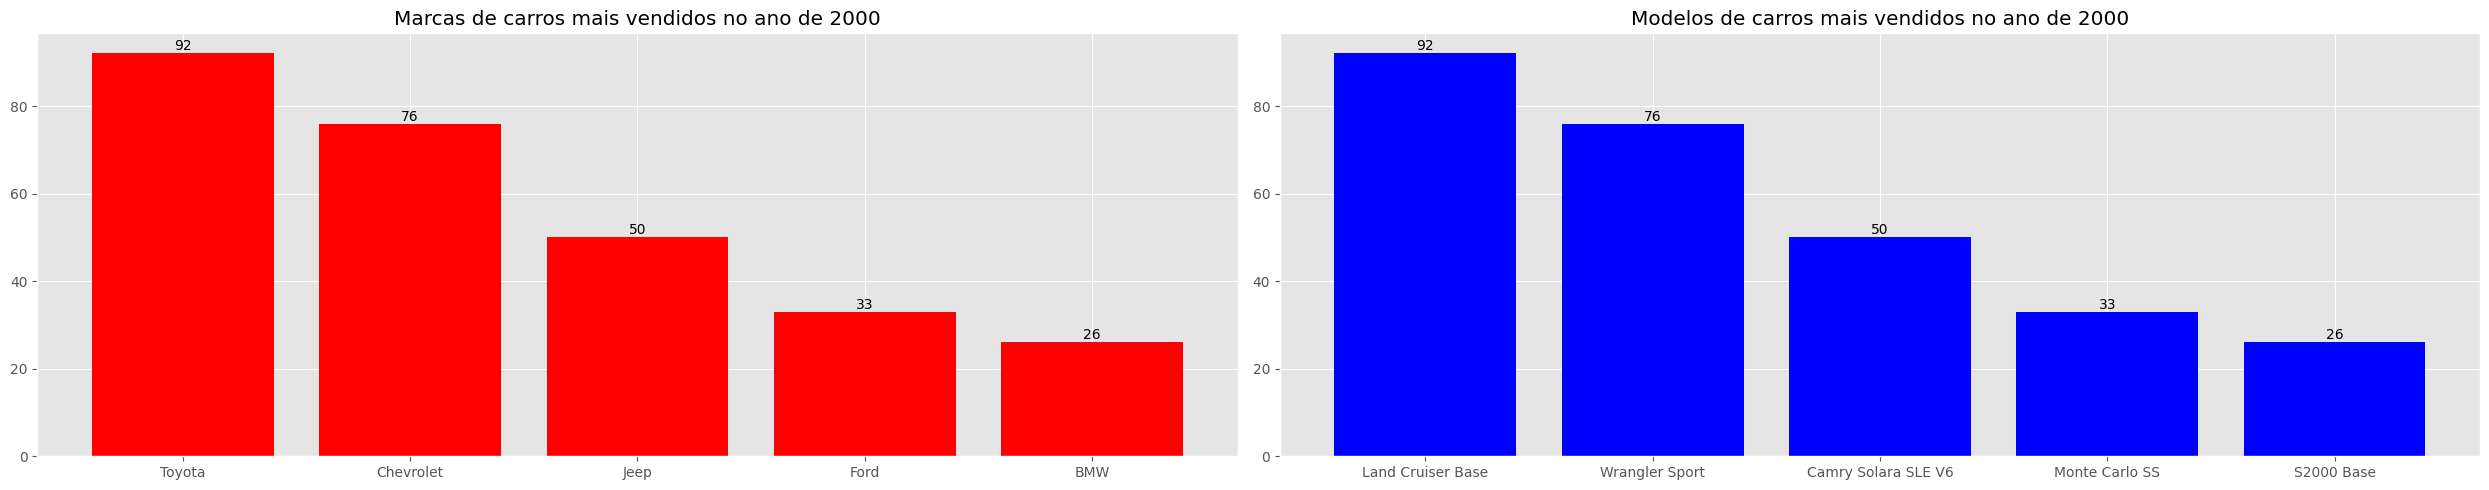

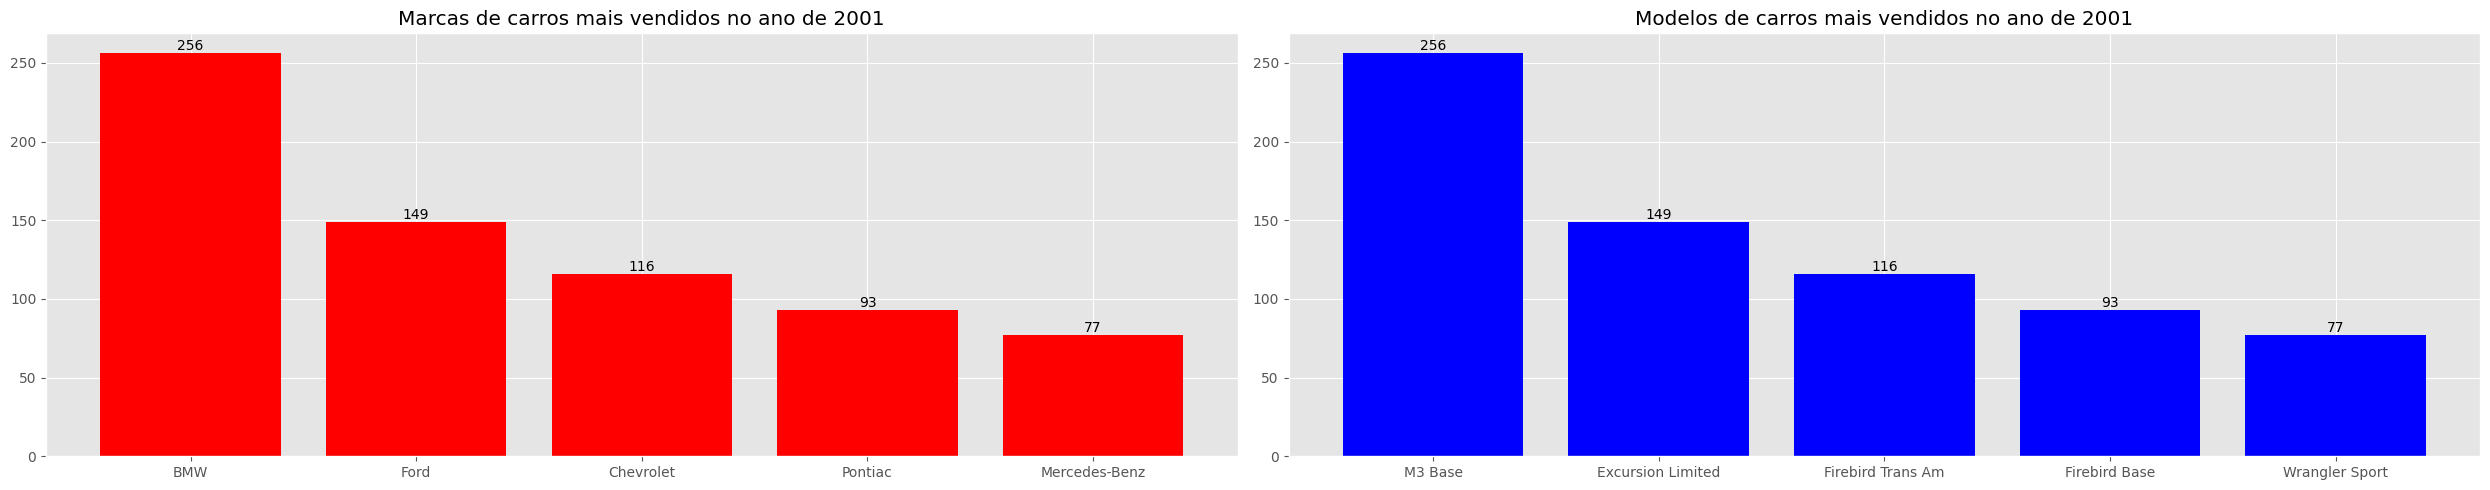

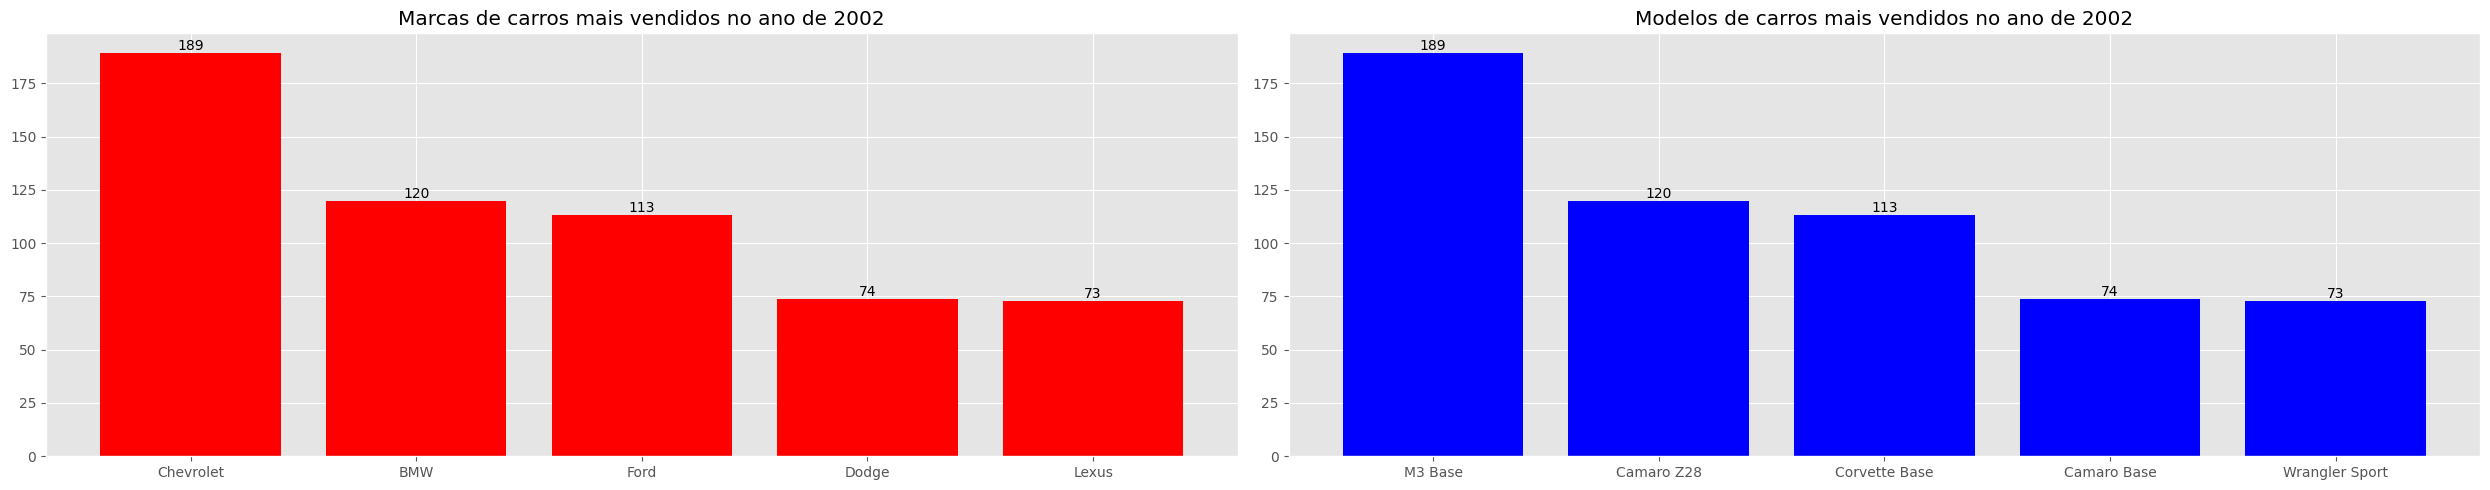

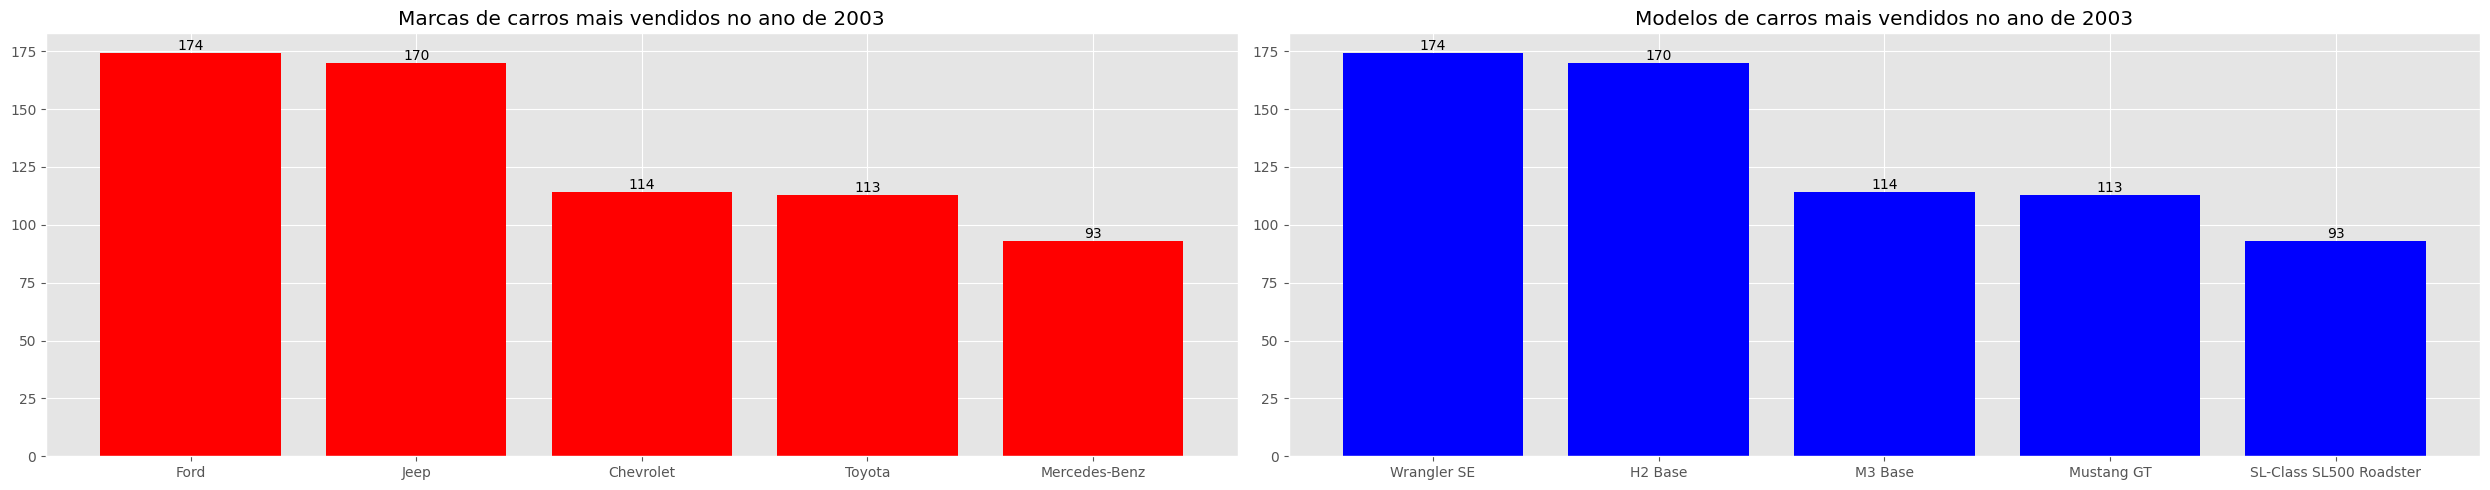

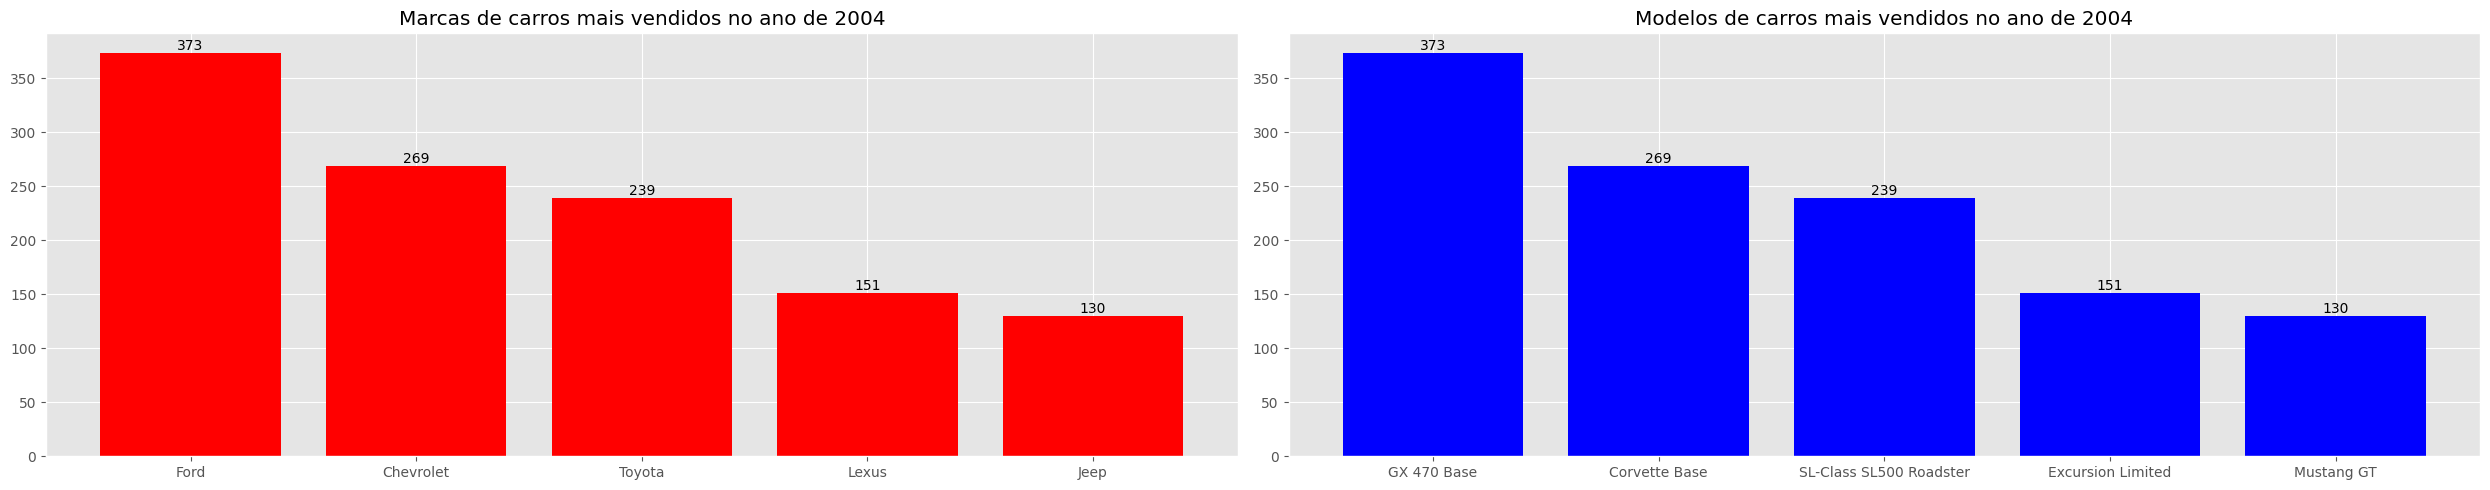

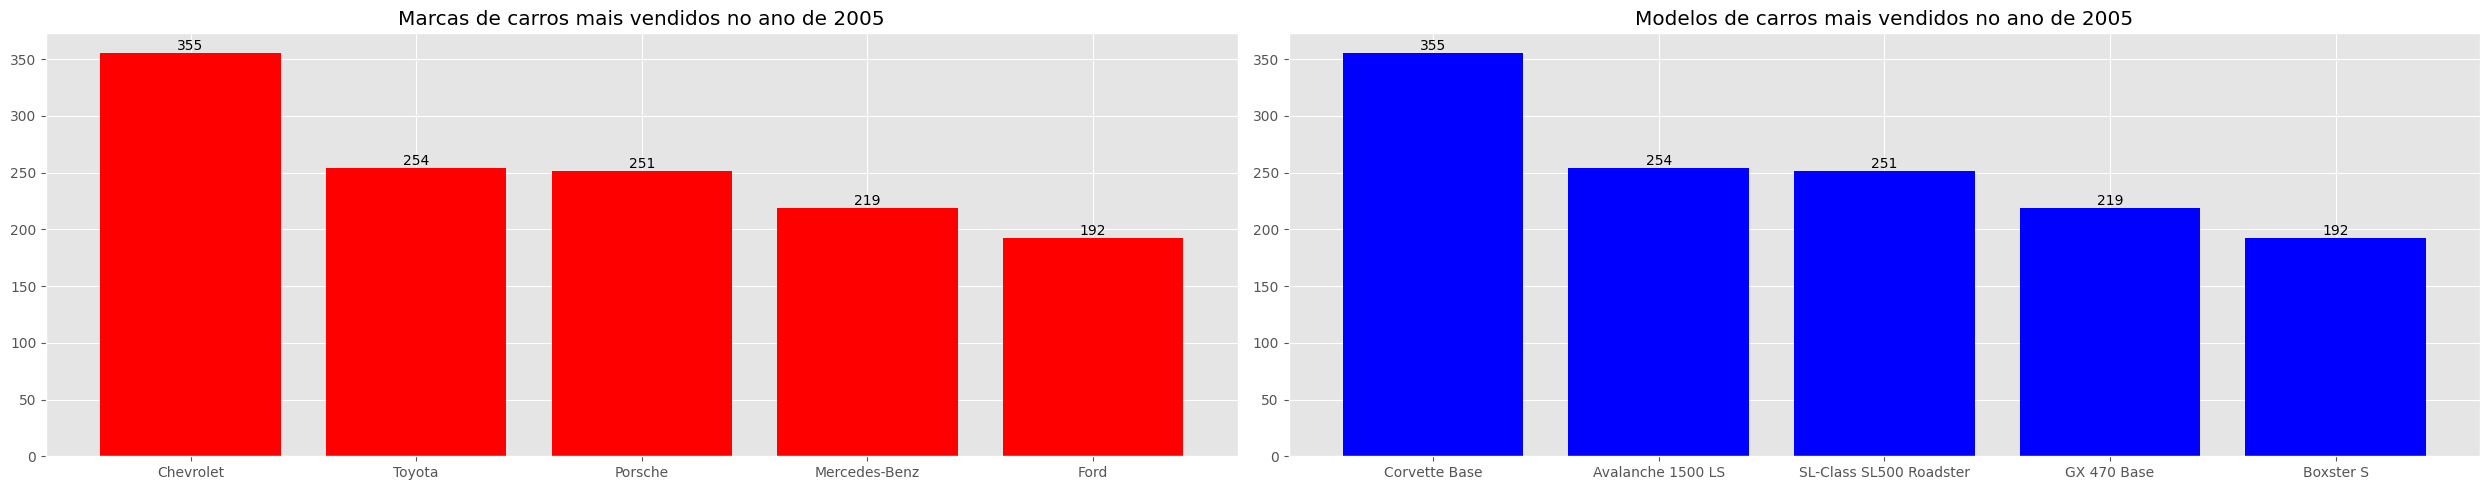

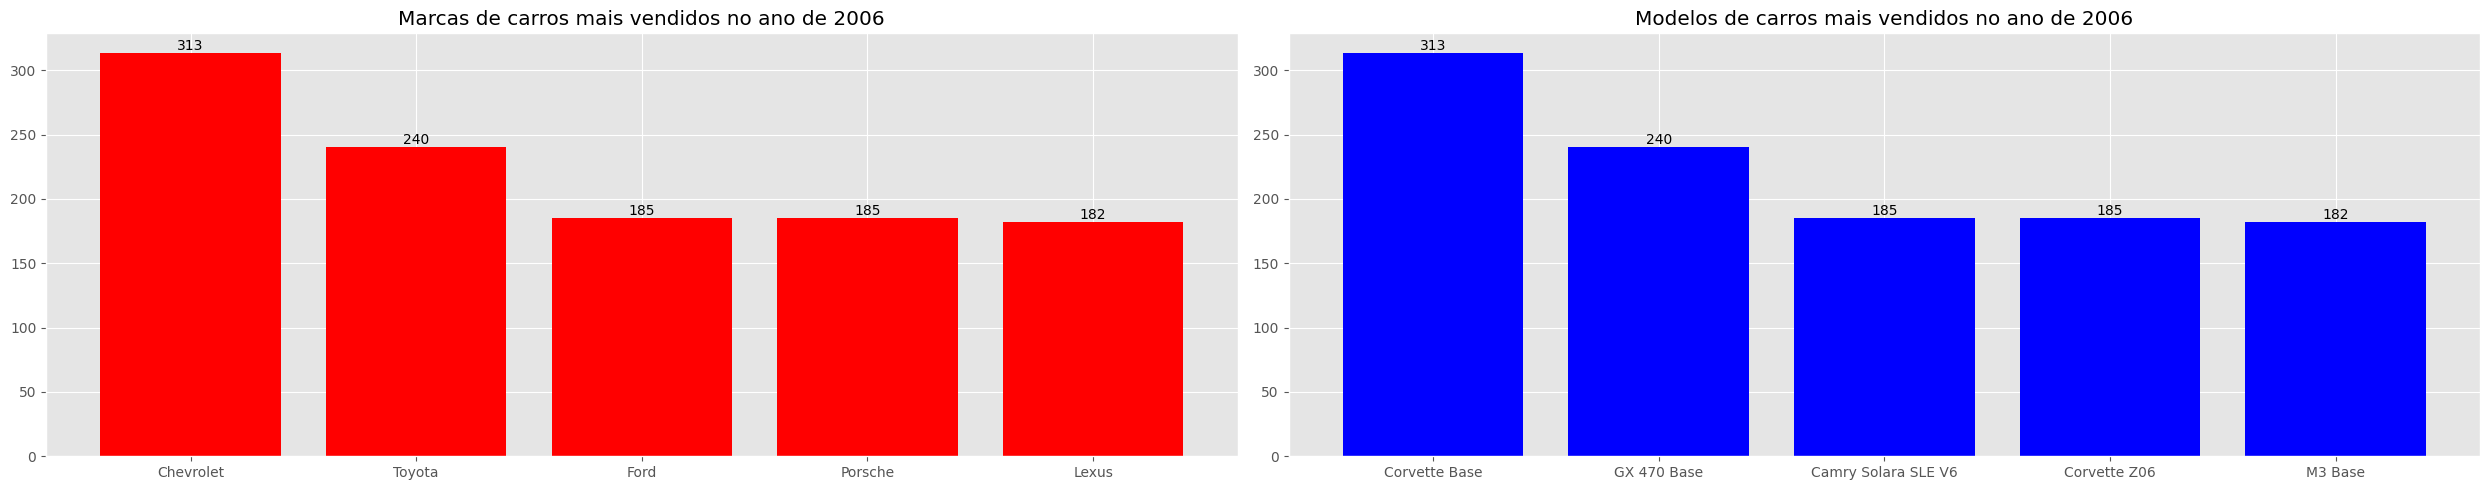

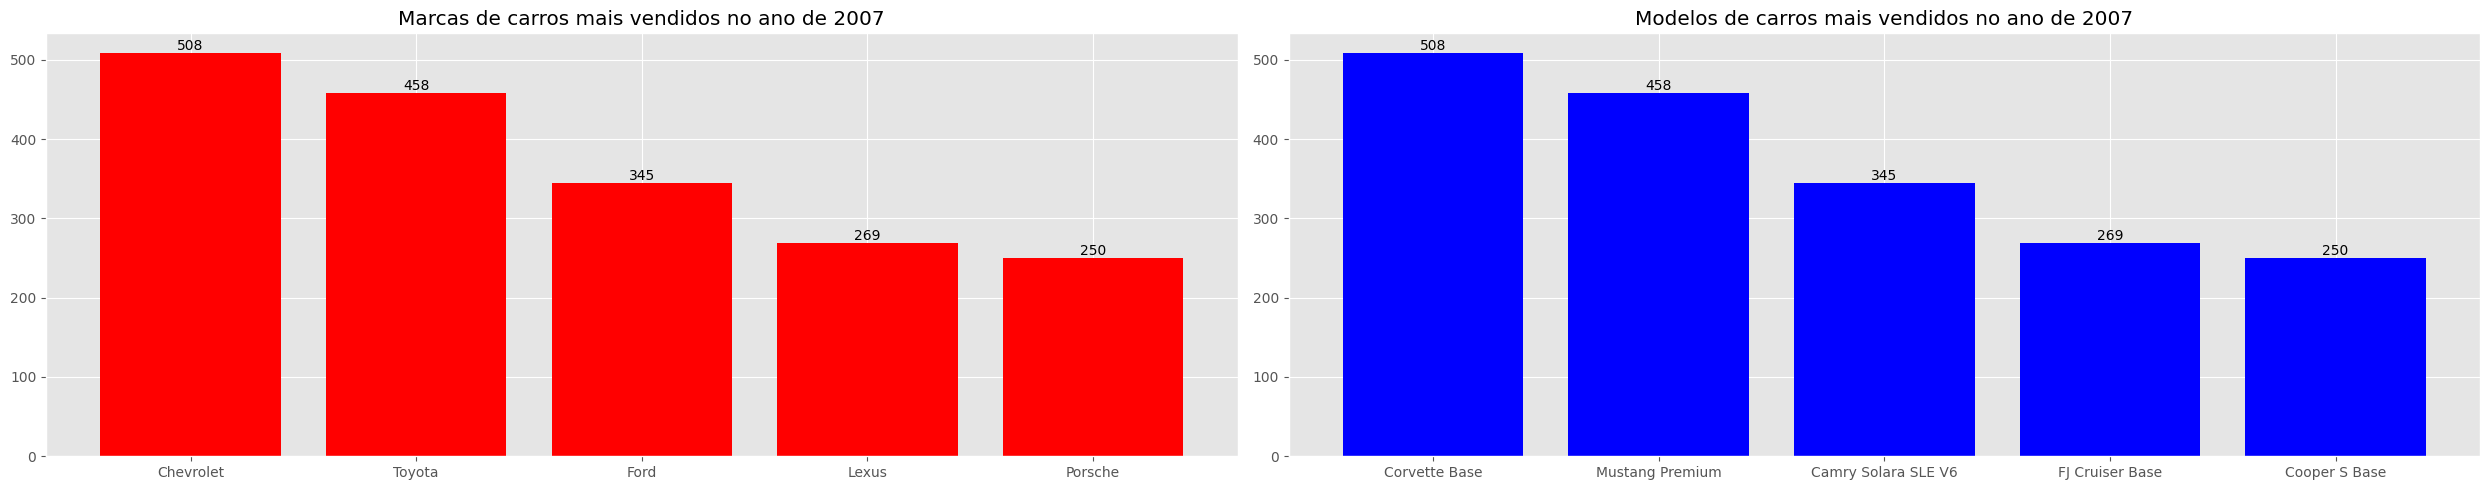

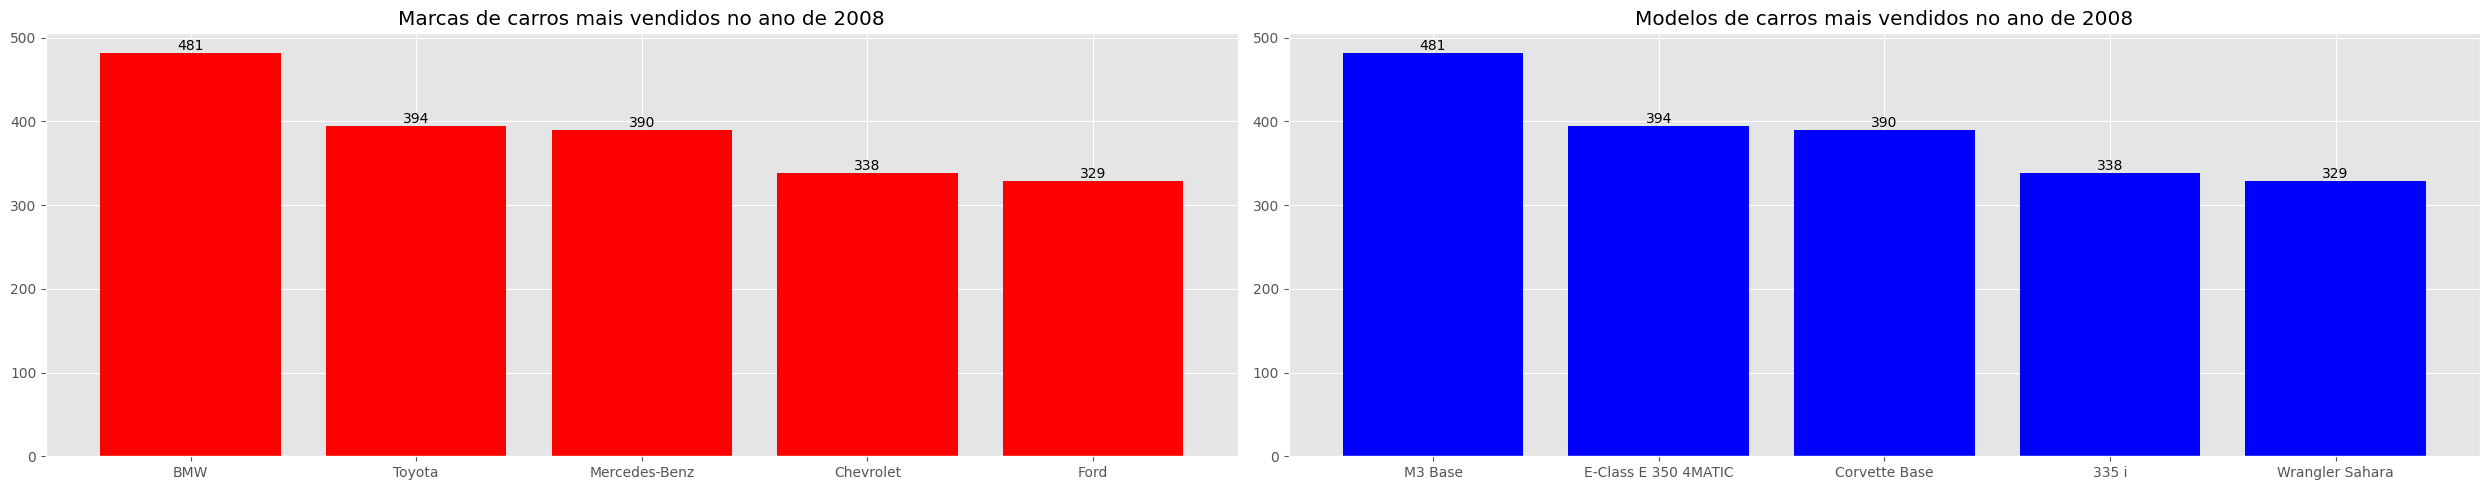

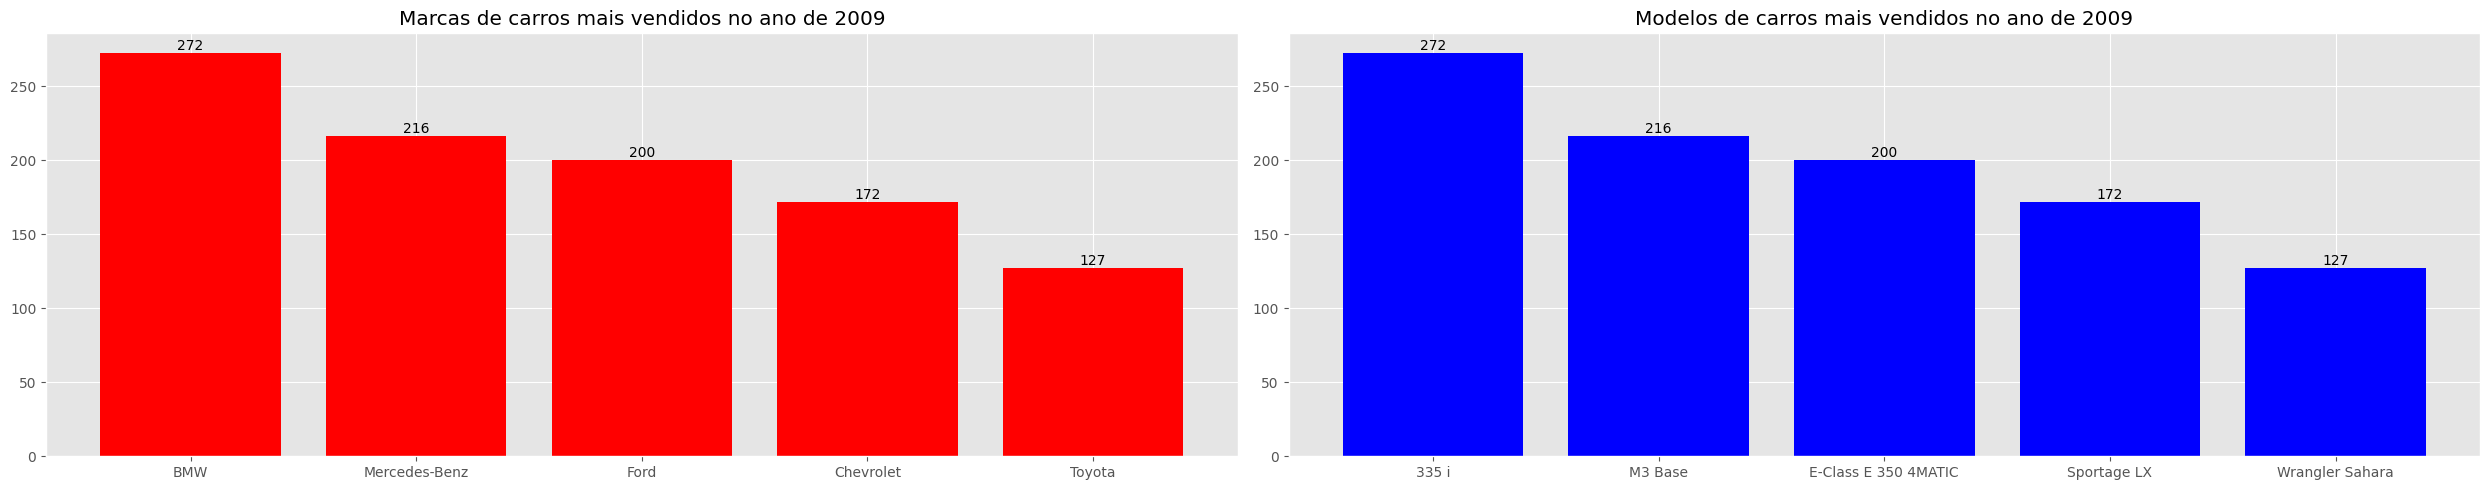

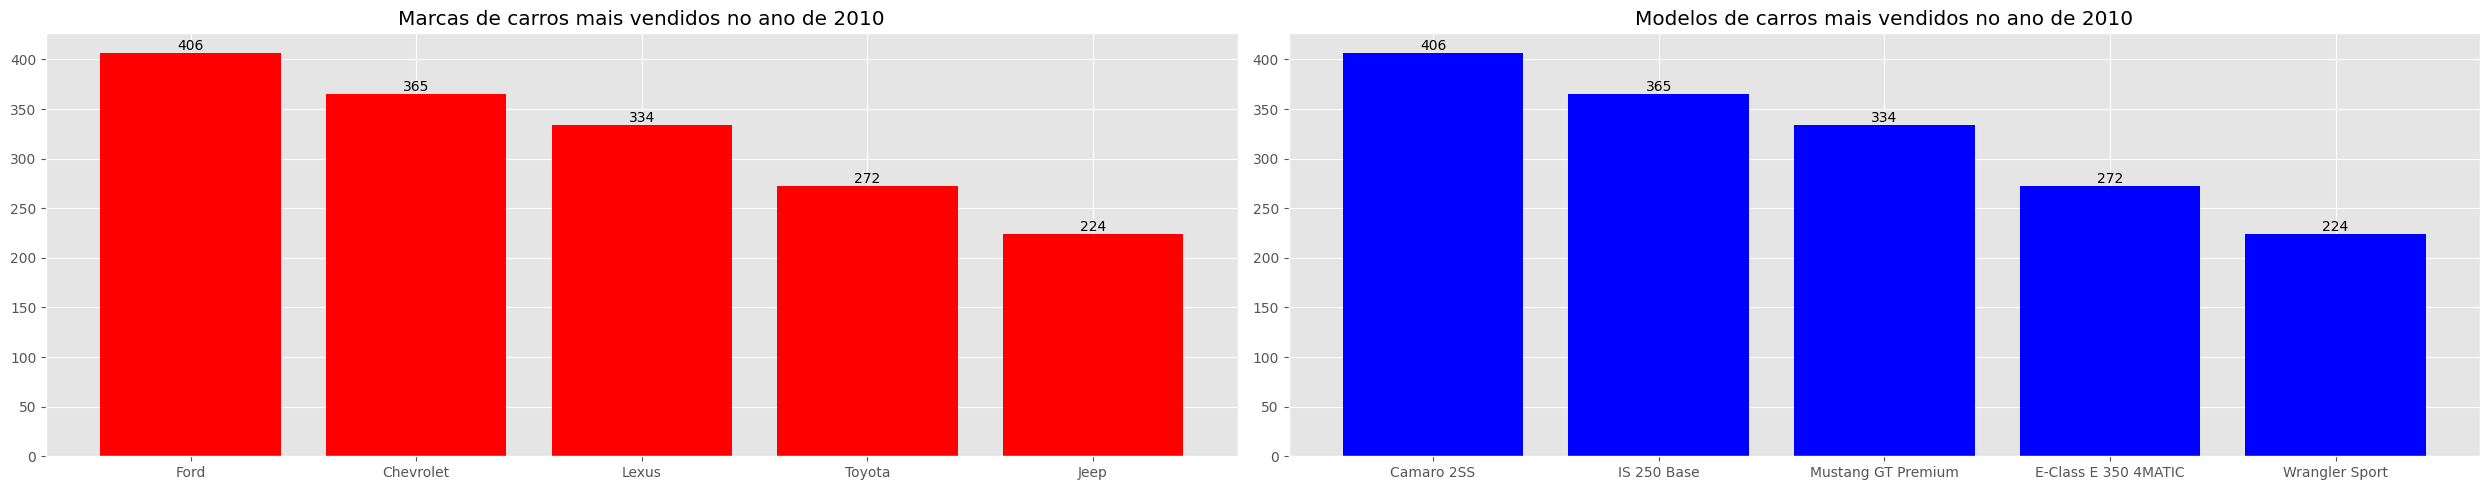

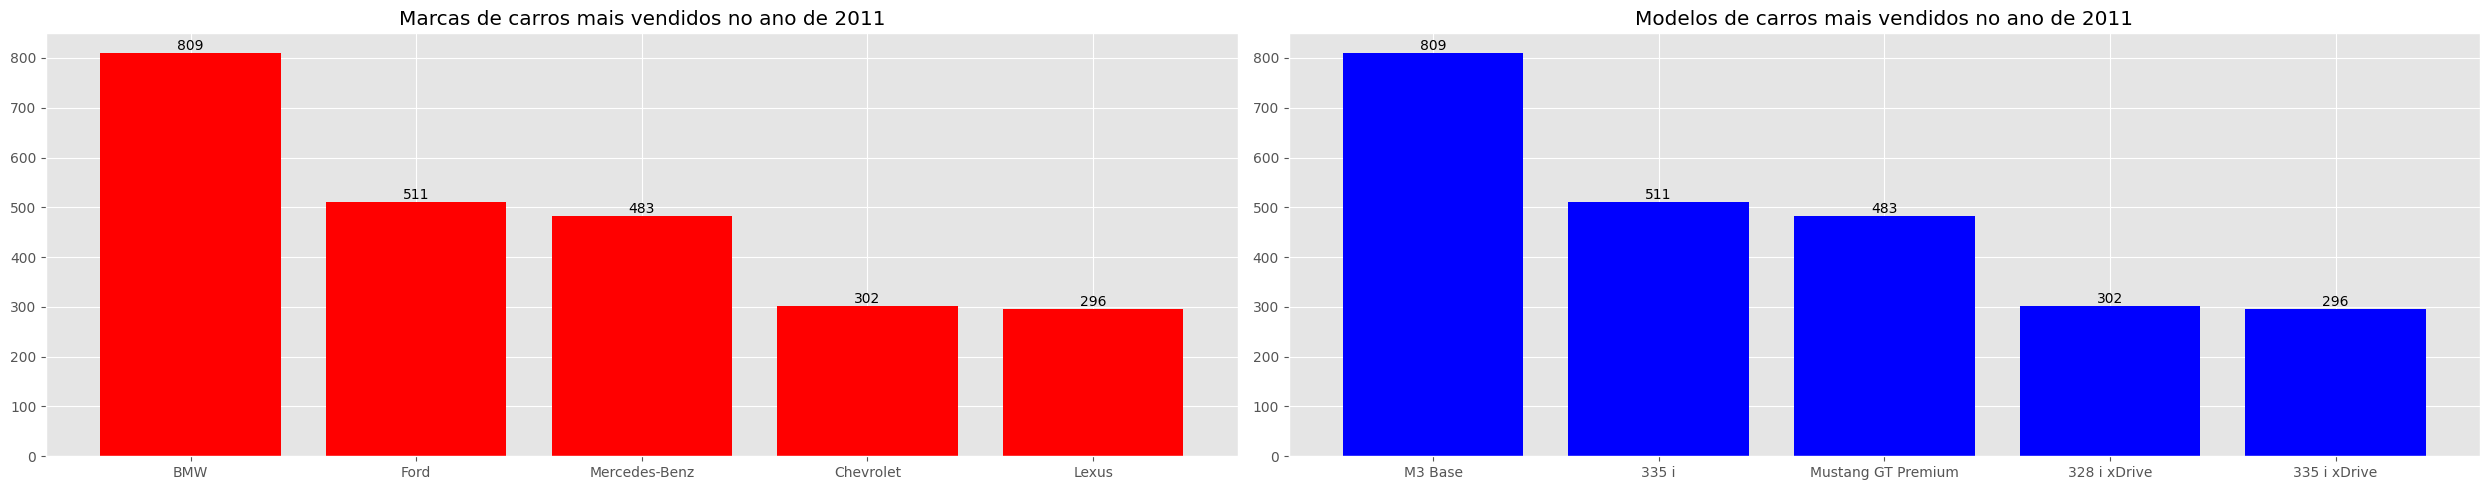

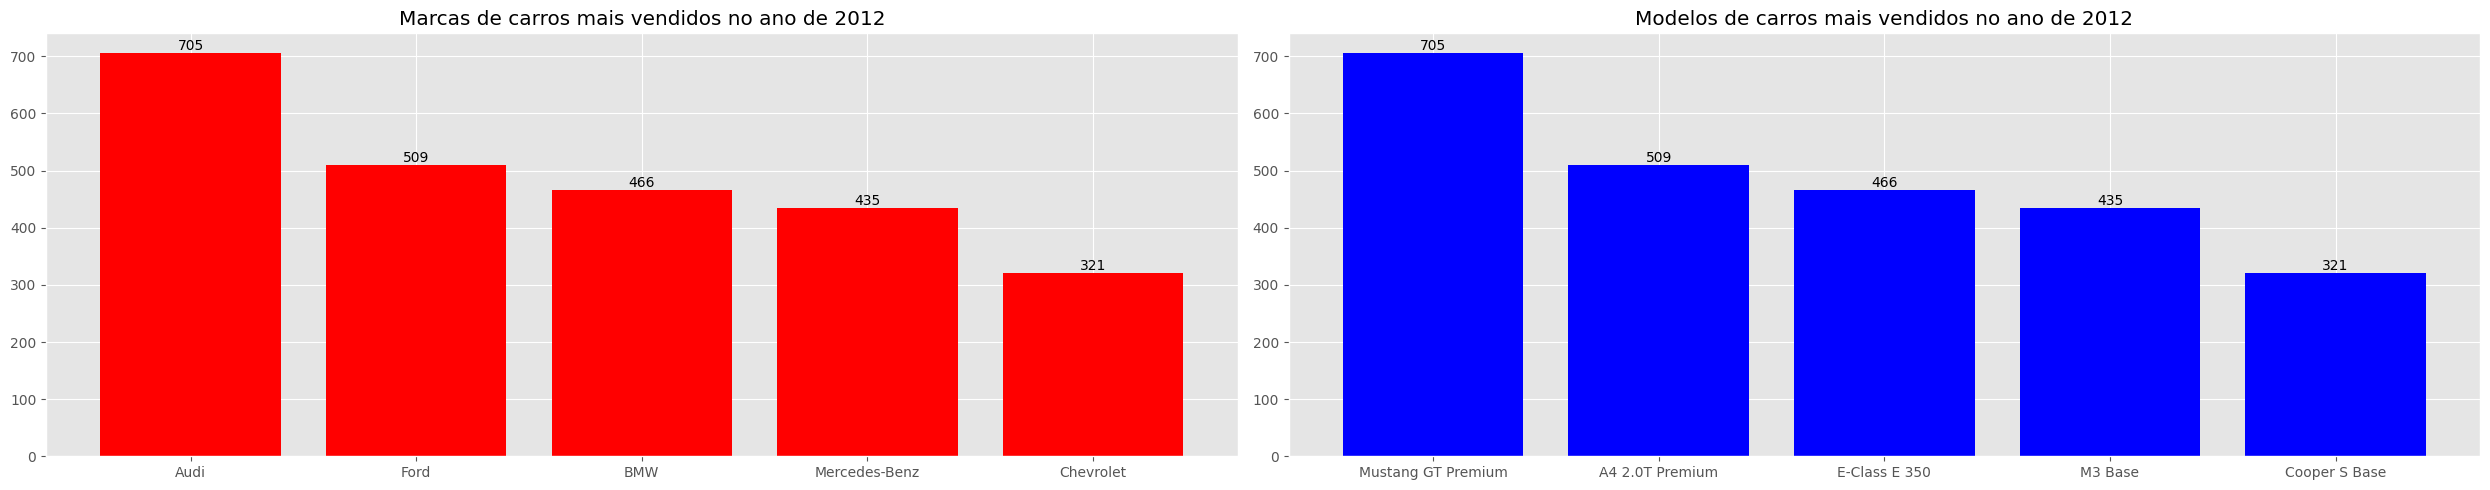

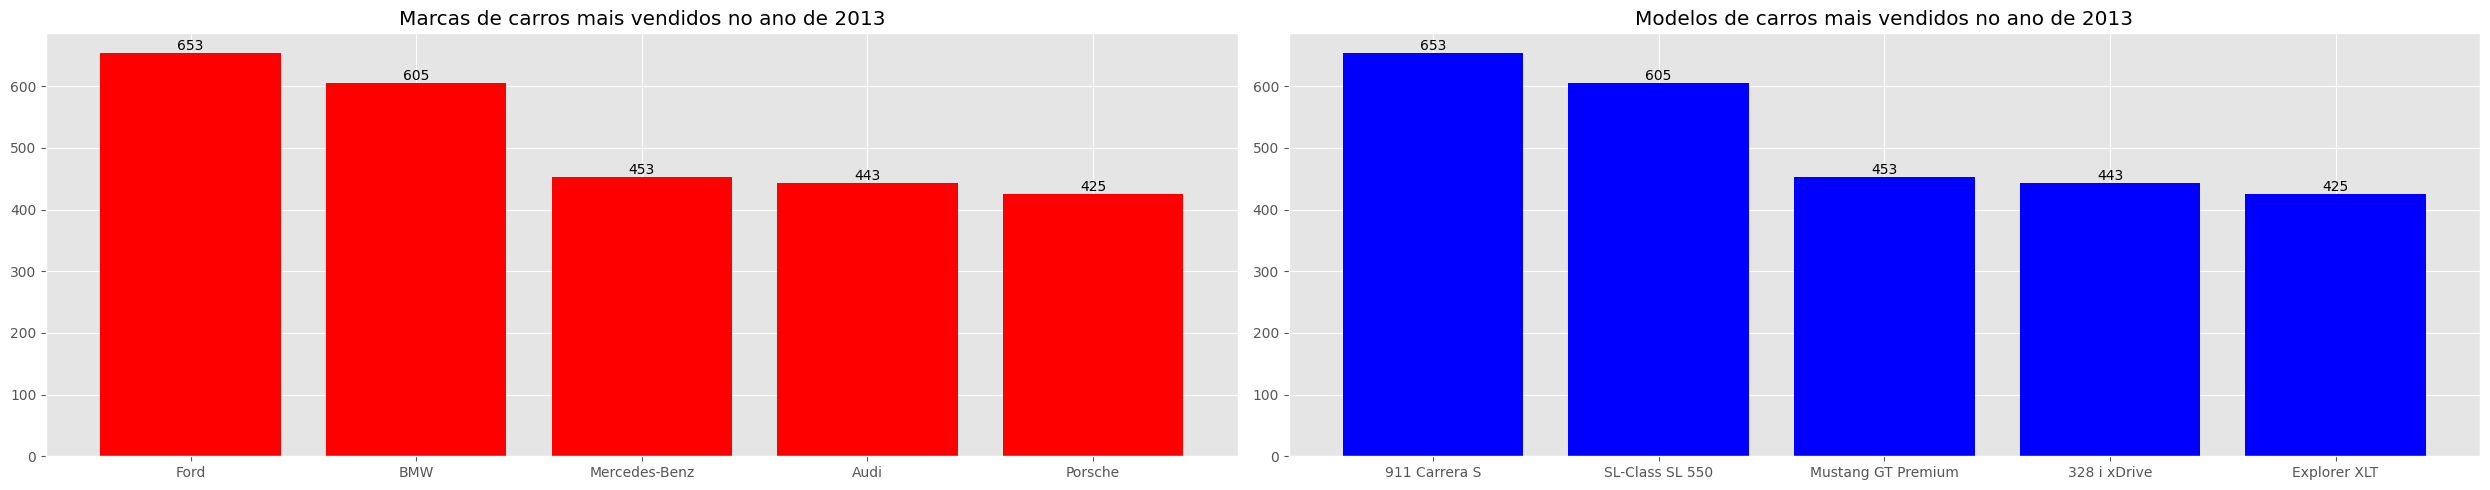

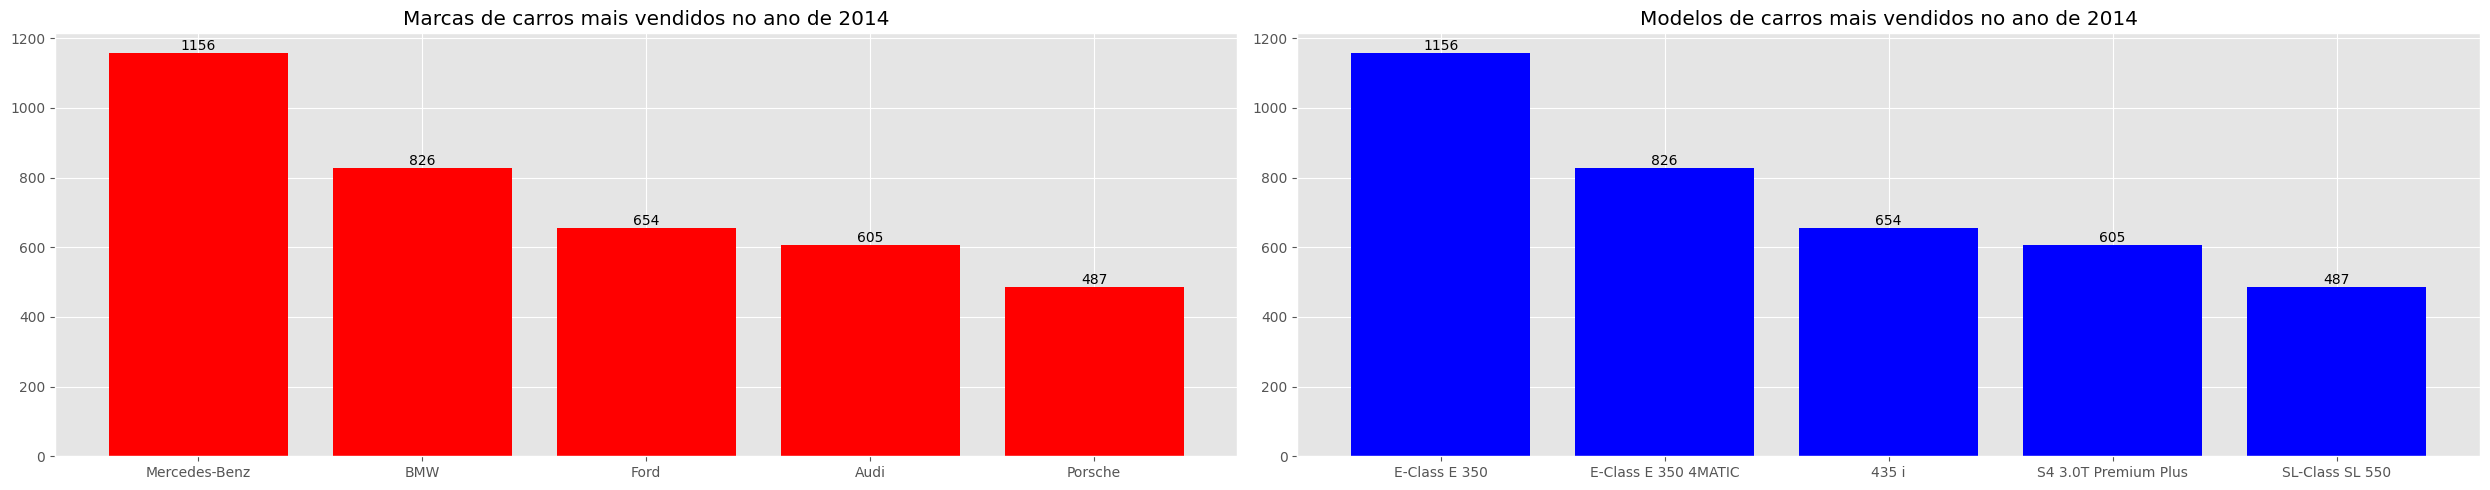

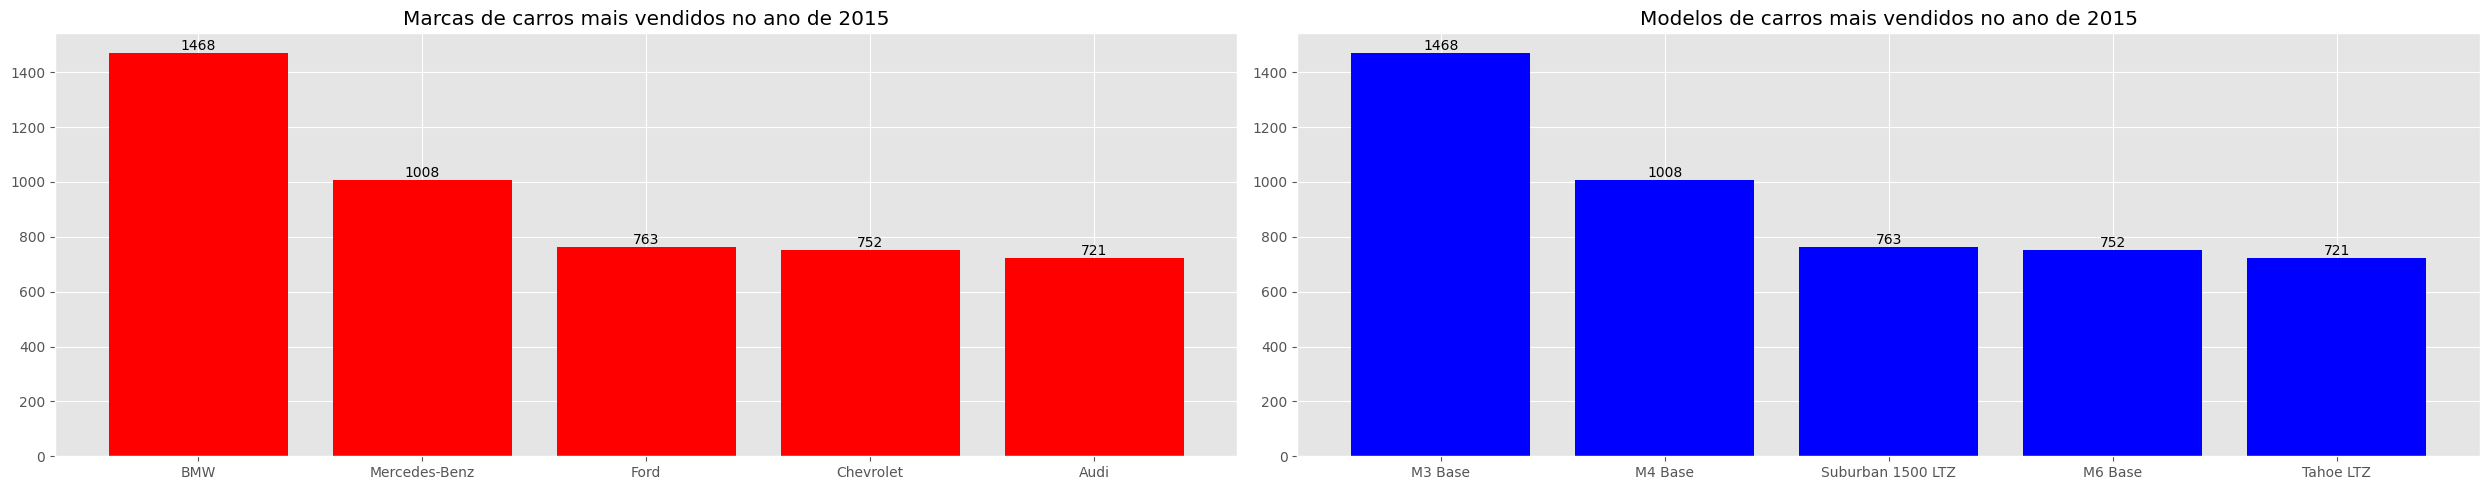

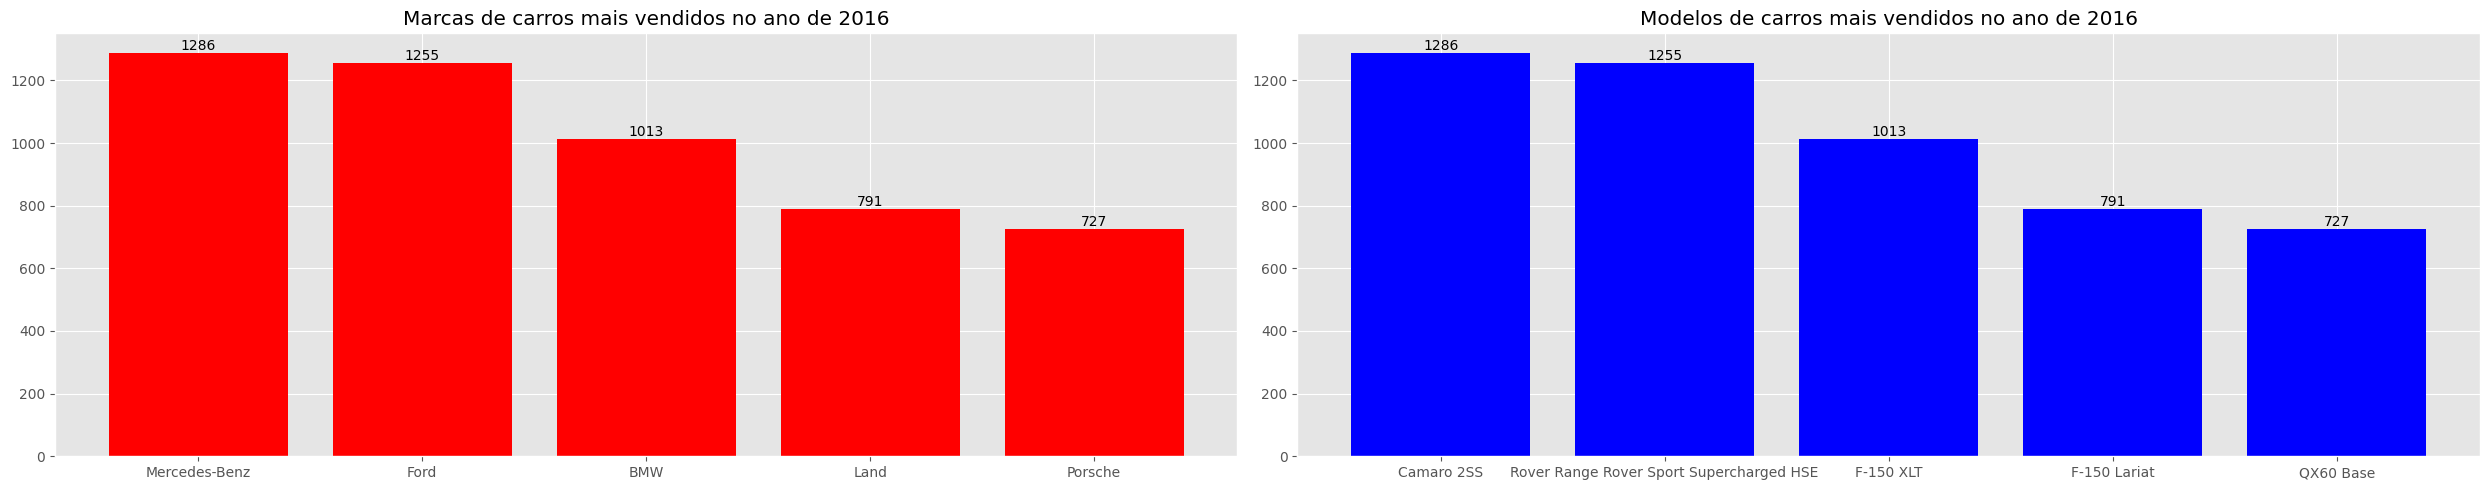

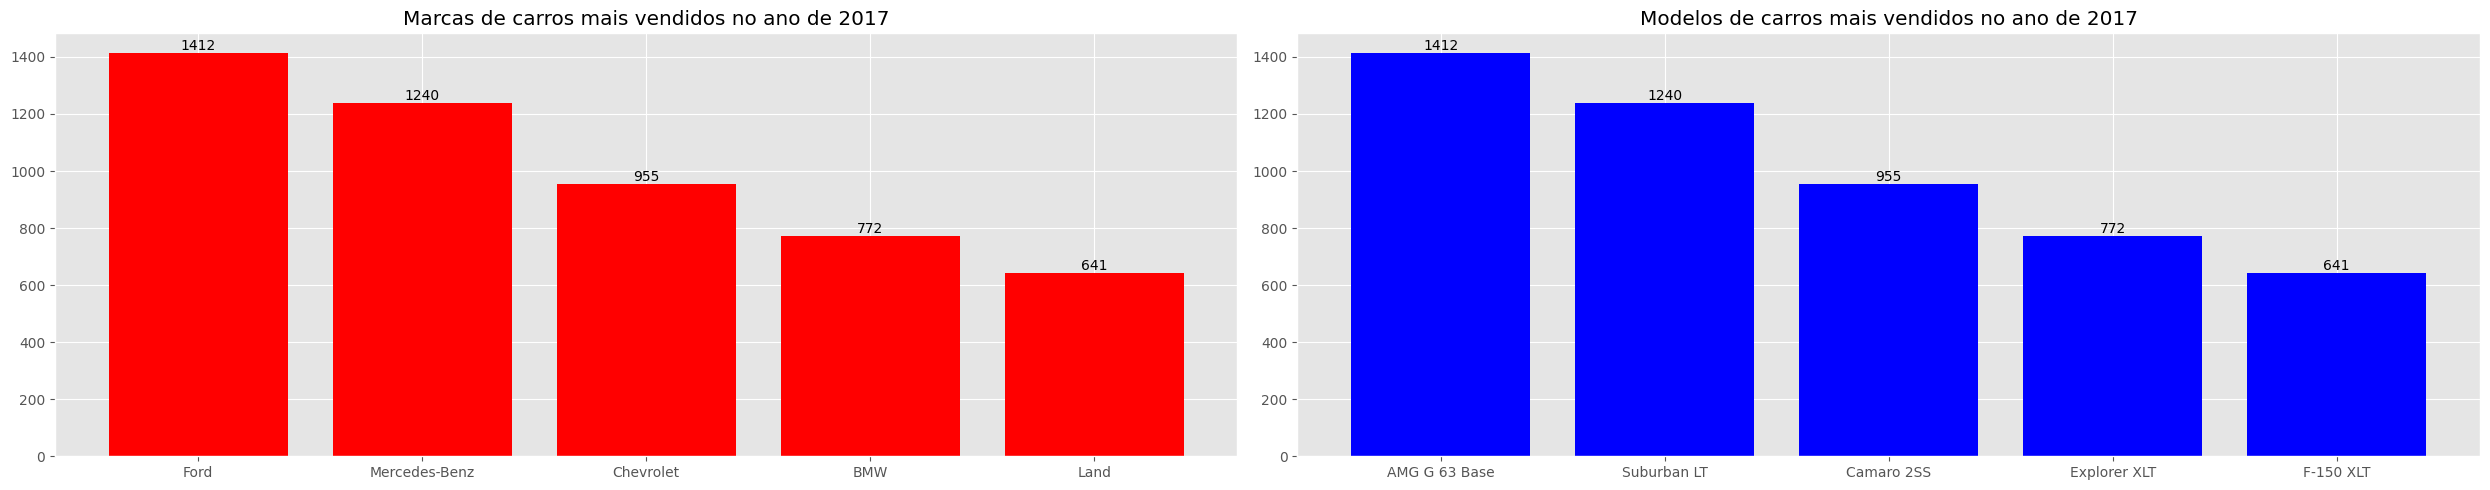

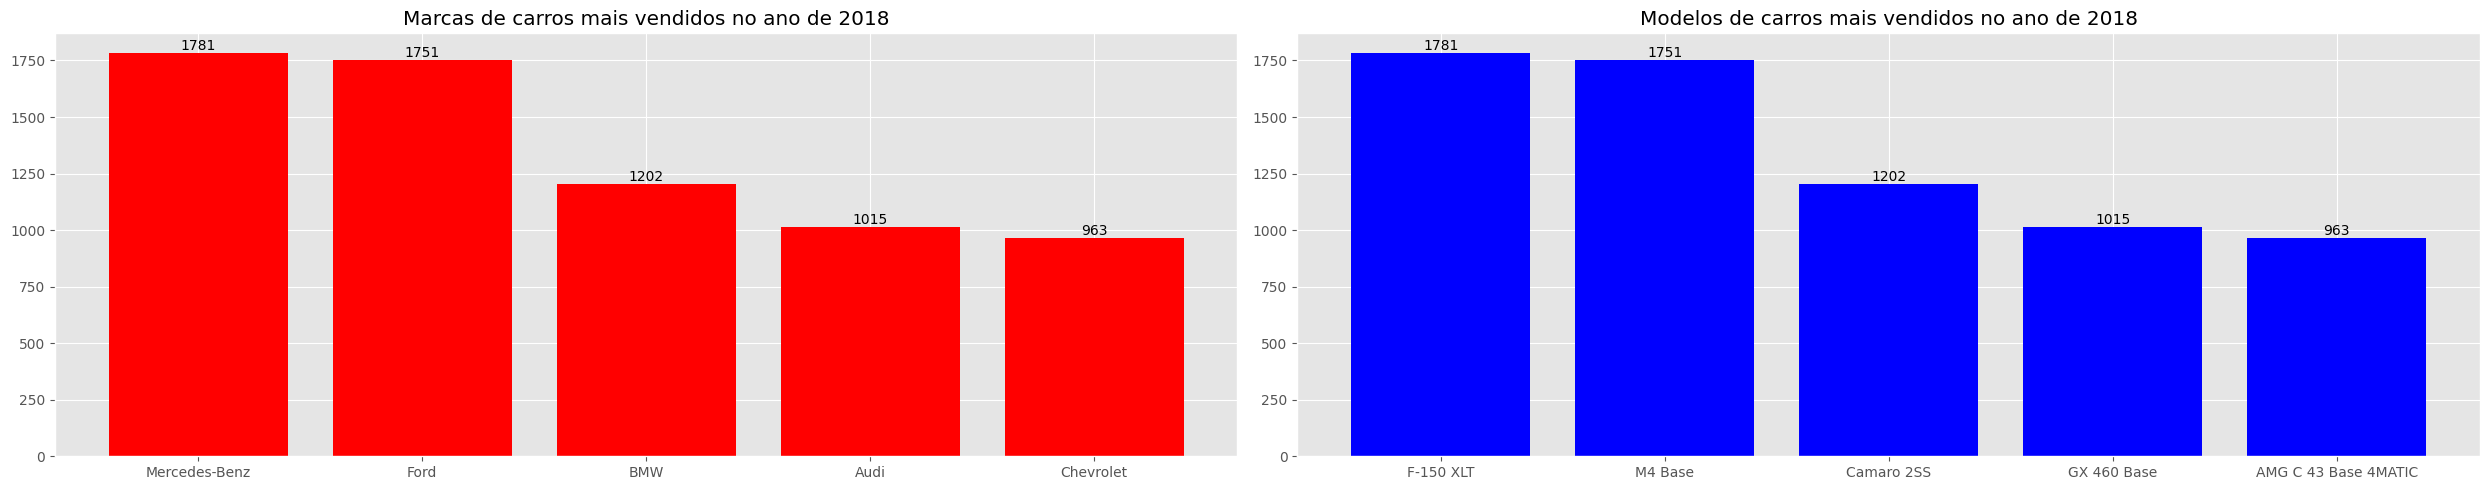

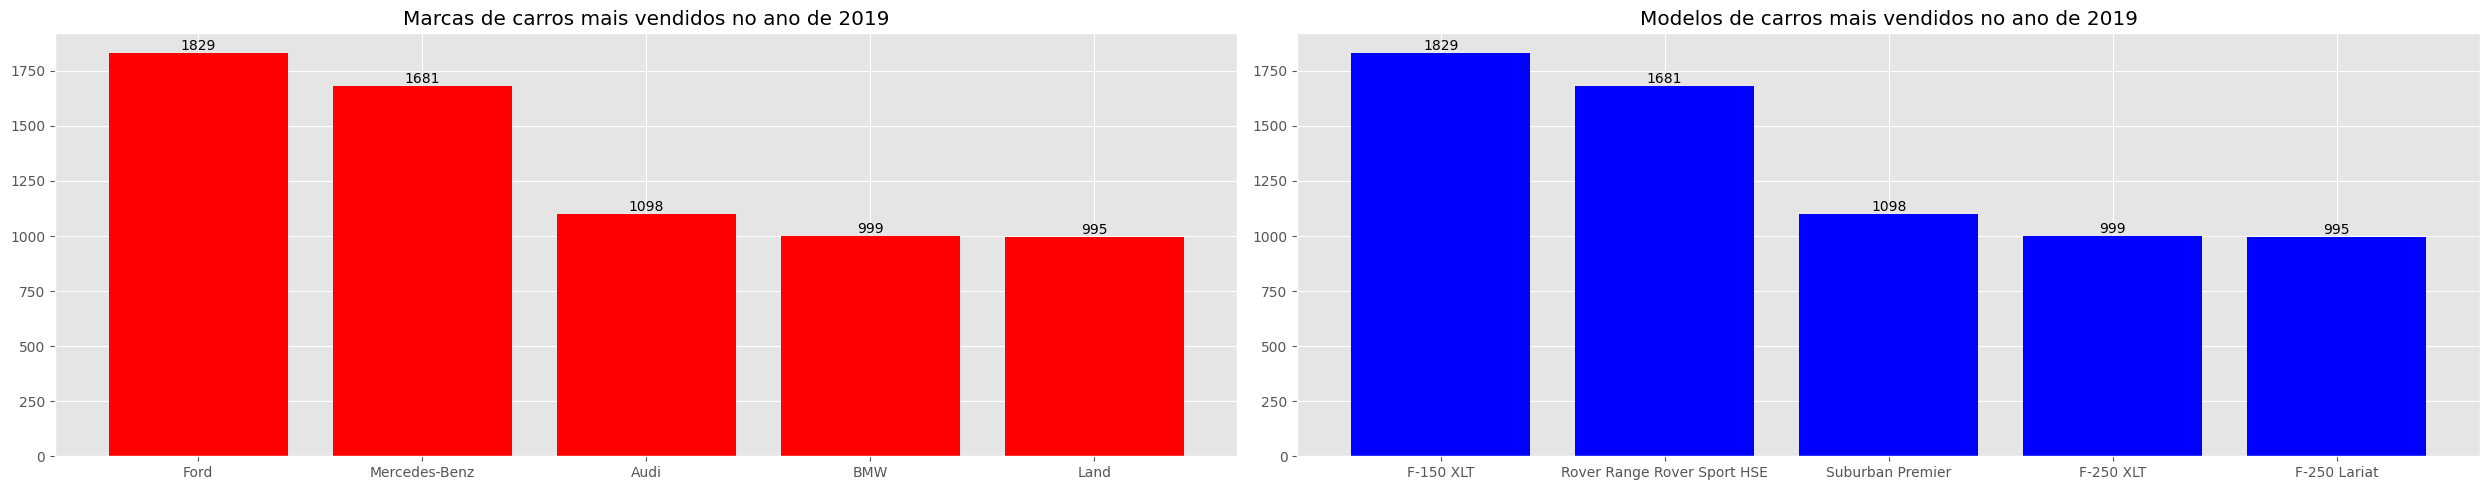

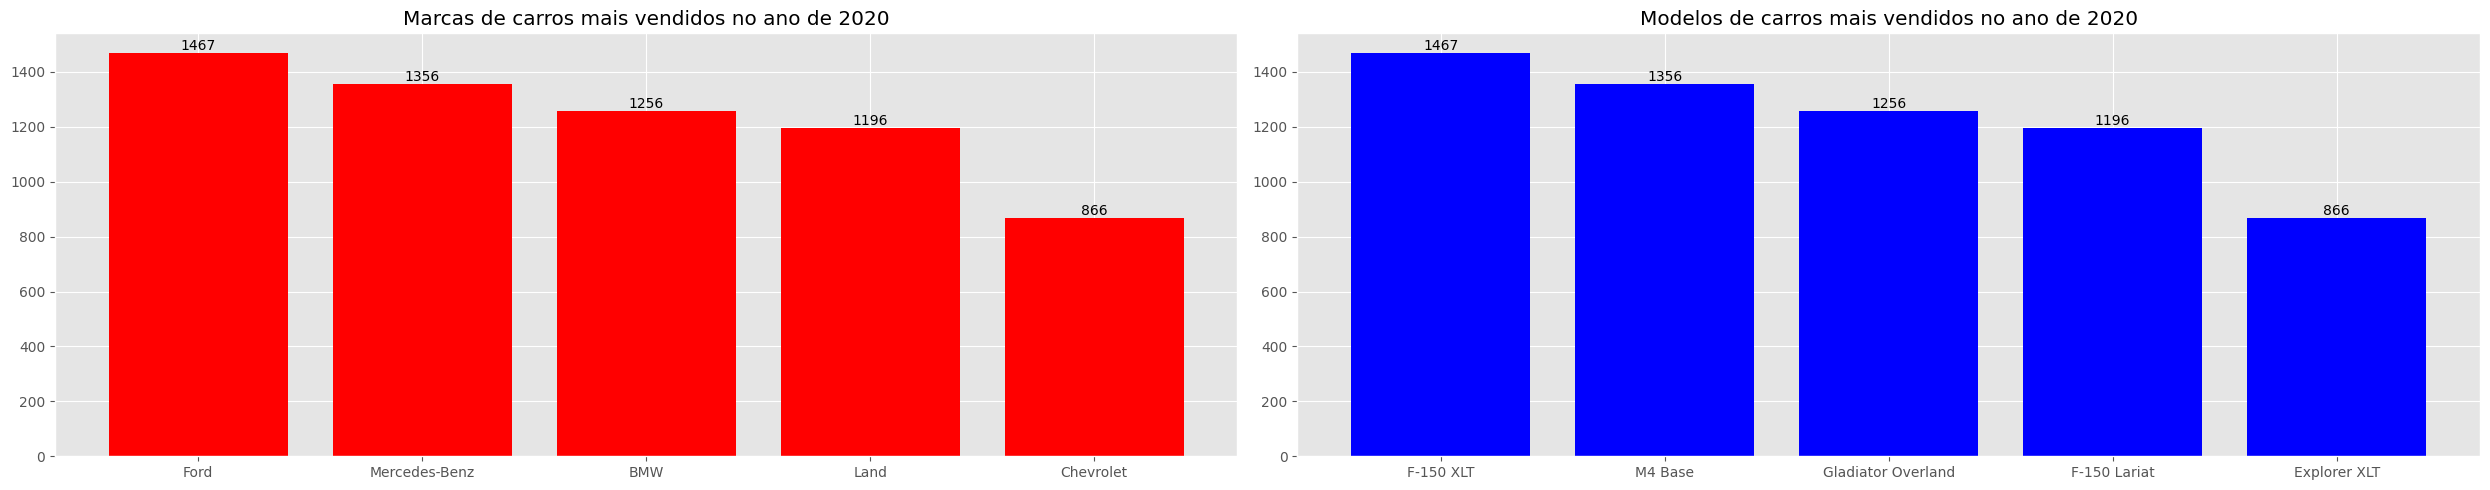

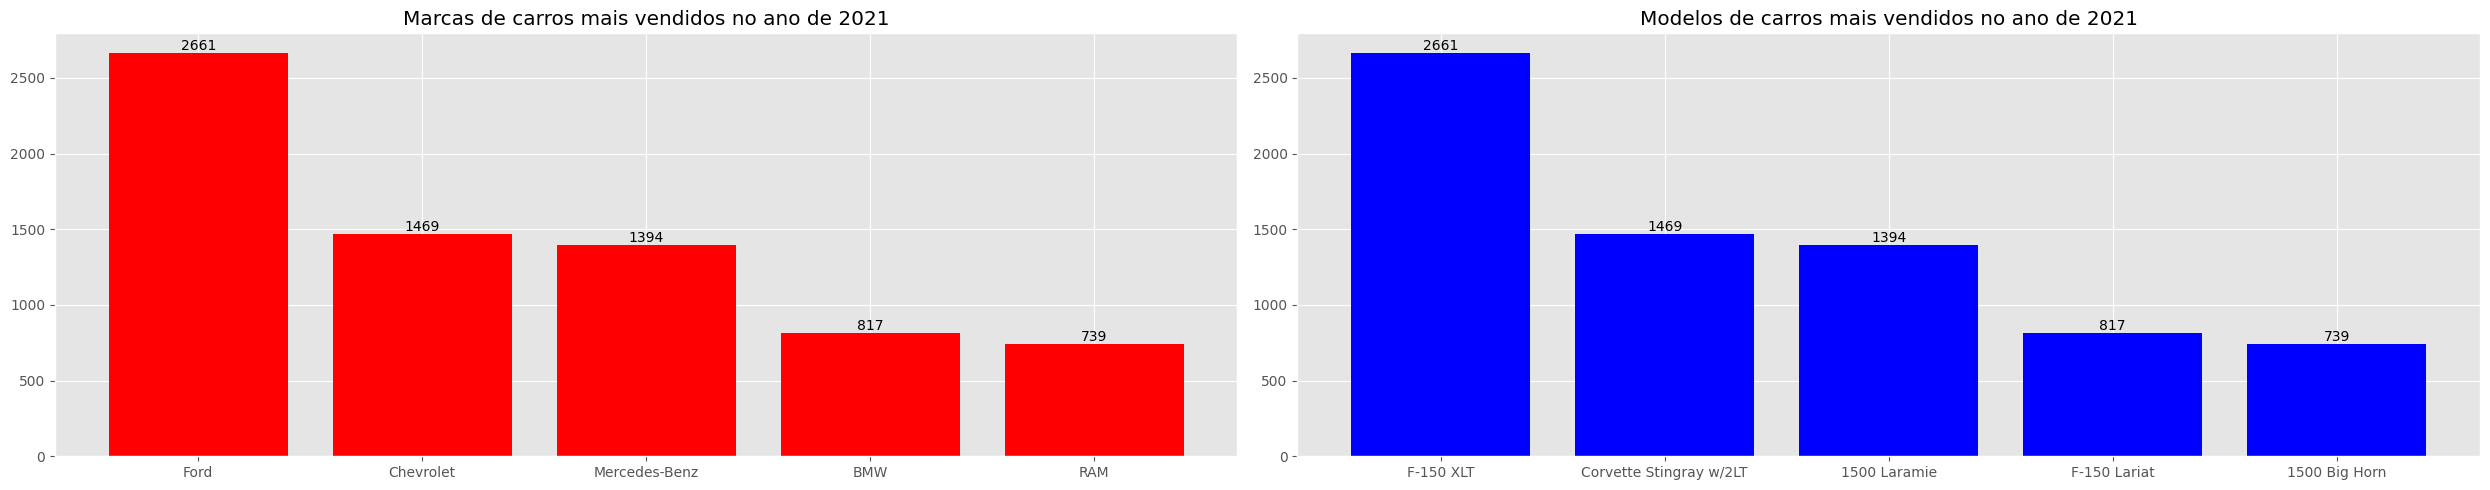

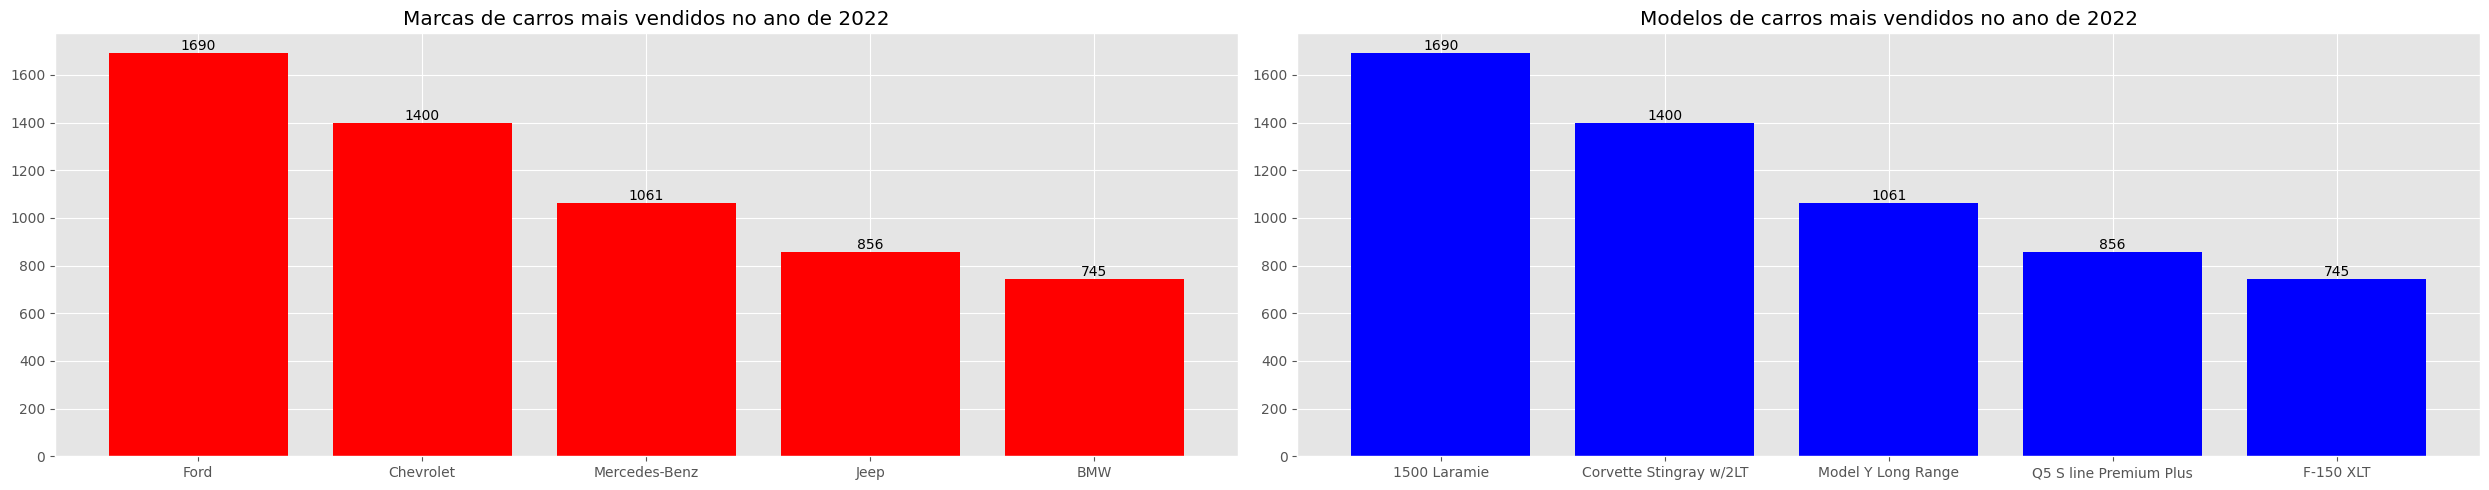

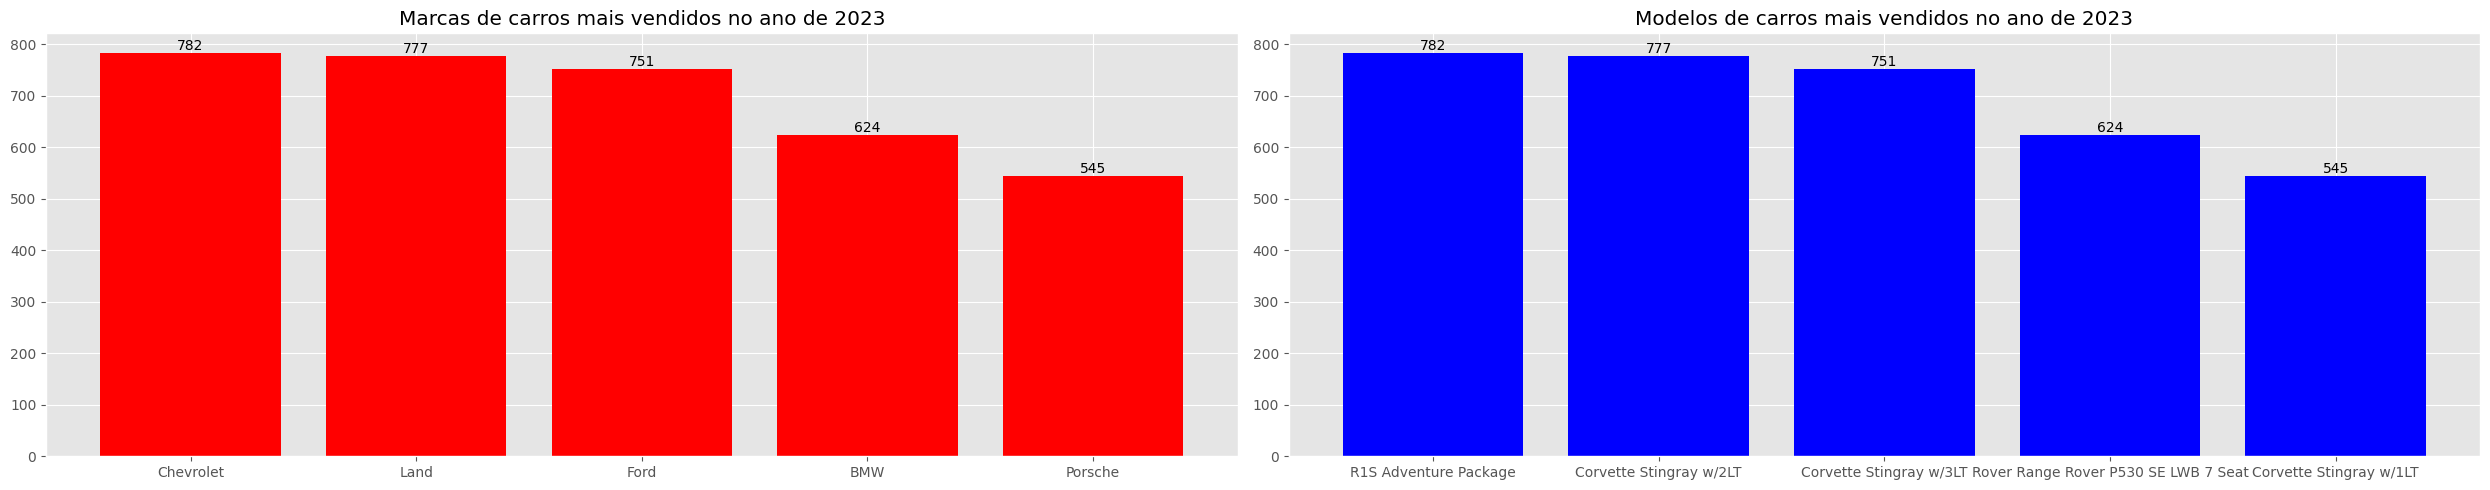

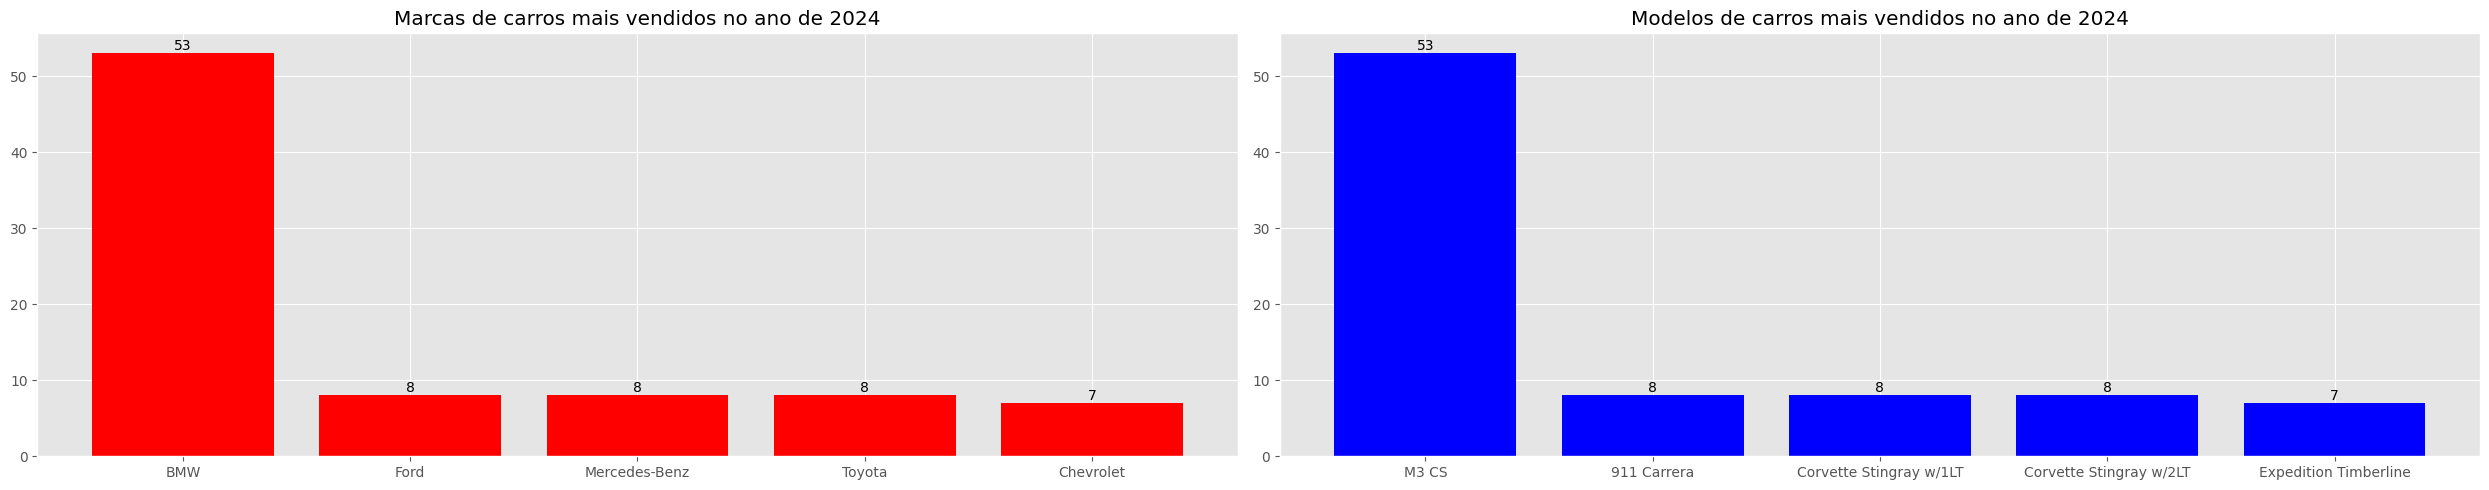

In [69]:
## os cincos modelos mais vendidos por ano
for ano  in sorted(train['model_year'].unique()):
    
    fig, axes = plt.subplots(1, 2, figsize=(25, 5))
    result_modelos = (
        train[train['model_year'] == int(ano)]
        .groupby("model_year")['model']
        .value_counts(ascending=False)
        .head(5)  # Pega as 5 primeiras ocorrências
        .reset_index(name='valor')  # Renomeia a coluna de contagem
    )
    
    result_marcas = (
            train[train['model_year'] == int(ano)]
            .groupby("model_year")['brand']
            .value_counts(ascending=False)
            .head(5)
            .reset_index(name='valor') 
        )

    axes[0].bar(result_marcas['brand'], result_marcas['valor'], color='red')
    axes[0].set_title(f'Marcas de carros mais vendidos no ano de {ano}')
    for index, value in zip(result_marcas['brand'], result_marcas['valor']):
        axes[0].text(index, value, f"{value:.0f}", ha="center", va="bottom")
    
    axes[1].bar(result_modelos['model'], result_marcas['valor'],color='blue')
    axes[1].set_title(f'Modelos de carros mais vendidos no ano de {ano}')
    for index, value in zip(result_modelos['model'], result_marcas['valor']):
        axes[1].text(index, value, f"{value:.0f}", ha="center", va="bottom")
    
    plt.tight_layout()
    plt.show()

Text(0.5, 1.0, 'As 20 marcas com a mediana de precos por ano mais caras.')

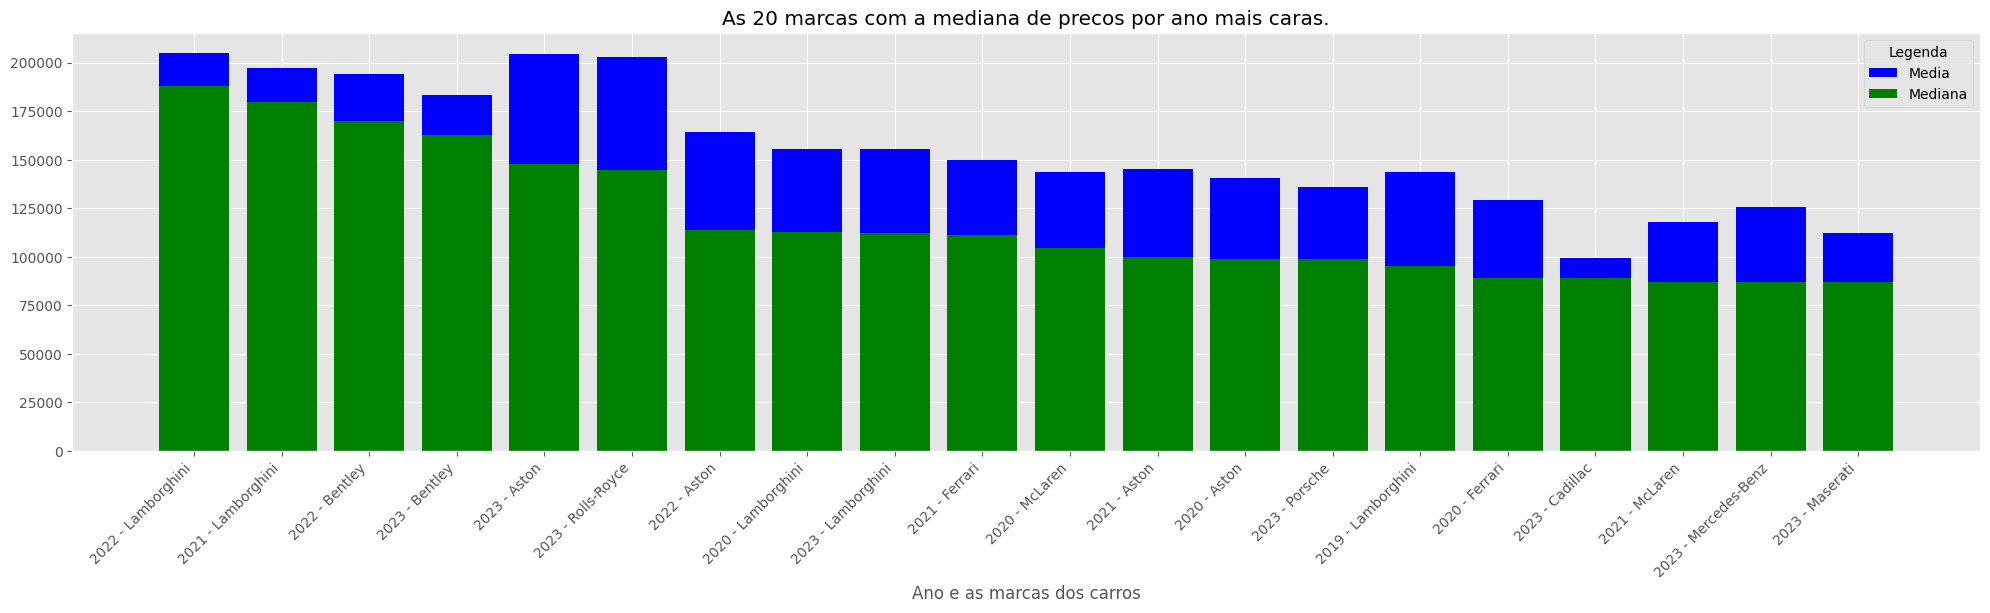

In [128]:

result = (
    train.groupby(["model_year", "brand"])['price']
    .agg(["mean", "median", "count"])
    .reset_index()
    .query('count > 10')
    .sort_values("median", ascending=False)
    .head(20)
    
)
eixo_x = [(str(ano)+' - '+ modelo) for ano, modelo in zip(result['model_year'], result['brand'])]
plt.figure(figsize=(20, 6))
plt.bar([(str(ano)+' - '+ modelo) for ano, modelo in zip(result['model_year'], result['brand'])], result['mean'],color='blue', label='Media')
plt.bar([(str(ano)+' - '+ modelo) for ano, modelo in zip(result['model_year'], result['brand'])], result['median'],color='green', label='Mediana')
plt.xlabel('Ano e as marcas dos carros')
plt.xticks(rotation=45, ha='right')
plt.legend(['Media', 'Mediana'],loc='upper right', title="Legenda", fontsize=10)
plt.tight_layout()
plt.title('As 20 marcas com a mediana de precos por ano mais caras.')

Text(0.5, 1.0, 'Os 20 modelos com a mediana de precos por ano mais caras.')

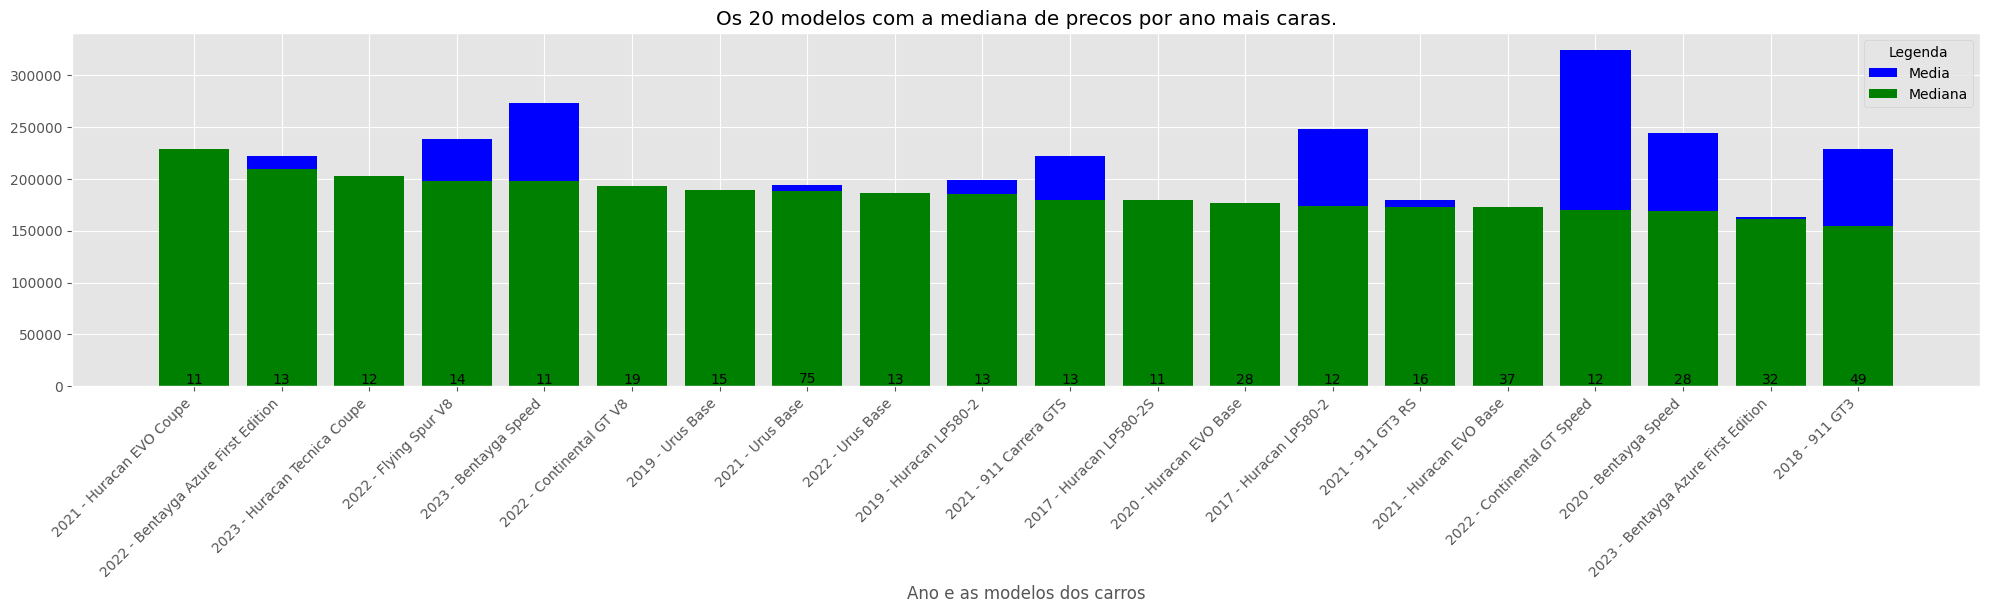

In [133]:
result = (
    train.groupby(["model_year", "model"])['price']
    .agg(["mean", "median", "count"])
    .reset_index()
    .query('count > 10')
    .sort_values("median", ascending=False)
    .head(20)
    
)
eixo_x = [(str(ano)+' - '+ modelo) for ano, modelo in zip(result['model_year'], result['model'])]
plt.figure(figsize=(20, 6))
plt.bar([(str(ano)+' - '+ modelo) for ano, modelo in zip(result['model_year'], result['model'])], result['mean'],color='blue', label='Media')
plt.bar([(str(ano)+' - '+ modelo) for ano, modelo in zip(result['model_year'], result['model'])], result['median'],color='green', label='Mediana')
eixo_x = [(str(ano)+' - '+ modelo) for ano, modelo in zip(result['model_year'], result['model'])]
for index, value in zip(eixo_x, result['count']):
    plt.text(index, value, f"{value:.0f}", ha="center", va="bottom")
plt.xlabel('Ano e as modelos dos carros')
plt.xticks(rotation=45, ha='right')
plt.legend(['Media', 'Mediana'],loc='upper right', title="Legenda", fontsize=10)
plt.tight_layout()
plt.title('Os 20 modelos com a mediana de precos por ano mais caras.')

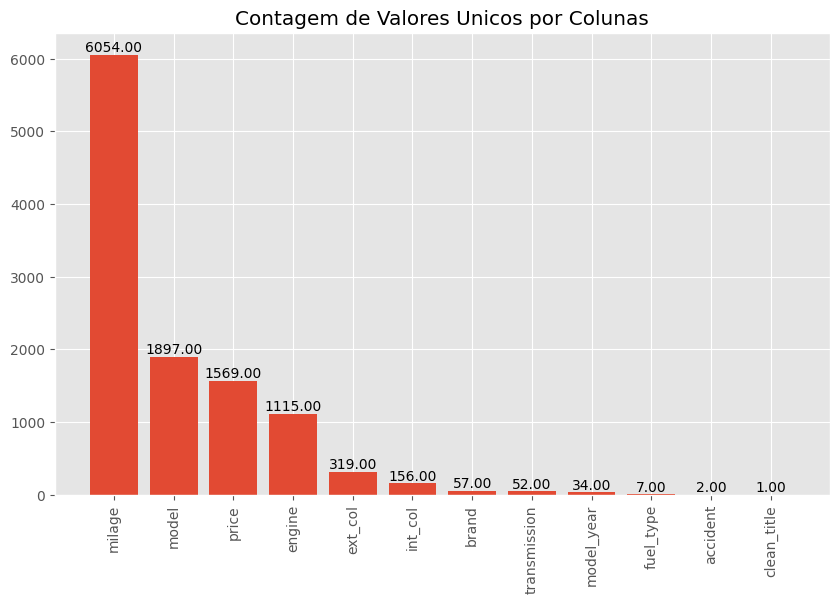

In [ ]:
train_nunique = train.nunique().sort_values(ascending=False)

plt.figure(figsize=(10, 6))

plt.bar(train_nunique.index, train_nunique.values)
plt.title("Contagem de Valores Unicos por Colunas")
plt.tick_params(axis="x", rotation=90)
for index, value in enumerate(train_nunique.values):
    plt.text(index, value, f"{value:.2f}", ha="center", va="bottom")


In [ ]:
fig = go.Figure()
fig.add_trace(
                go.Bar(x=train_nunique.index, y=train_nunique.values)
            )
fig.update_layout(
                title="Quantidade de Valores Unicos por Colunas",
                xaxis_title="Colunas",
                yaxis_title="Valores",
                width = 1000,
                height=500,
                margin=dict(l=5, r=5, t=40, b=5)
            )
fig.show()